# Applied Deep Learning
# Group 8 - Insurance Fraud Detection coursework

## Task 1: The detection rate and the hit rate 

The detection rate refers to the percentage of cases that are flagged by a fraud detection system as potentially fraudulent which requires further investigation, out of all the cases. The hit rate refers to the percentage of actual fraud cases that are identified by a fraud detection system, out of all the cases that are further investigated. 

High detection rates indicate that the system is flagging a high number of cases for further review, which can help identify potential fraud. However, since there are over 10,000 claims in the dataset, high detection rates may give rise to a high estimated cost of time and money spent on the manual investigation. If the hit rate is low, it may indicate that the system is flagging too many cases, including false positives, which can not only lead to additional time and costs but also result in overlooking the real frauds due to insufficient human capacity or budget.

Conversely, a high hit rate means that the system is correctly identifying a high percentage of actual fraud cases, which can help prevent significant losses for the insurer. This will potentially reduce premiums and raise reimbursement rates, which will benefit policyholders and thus help the insurance company gain a good reputation and expand its customer base. In contrast, a model with a low detection rate does not indicate lenience - Suppose the fraud rate is 1/100, then a perfect model would only have a detection rate of 1%. However, that is rarely the case.

Ultimately, insurers aim to strike a balance between the hit rate h and detection rate d and our objective is to evaluate a model which can help to flag a moderate but sufficient number of suspicious cases for further review which allows us to find the 100 frauds as accurate as possible. 

In [1]:
import datetime
import random

import graphviz
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.display import Image
from scipy.stats import randint
from sklearn import metrics, tree
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score, log_loss,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

## Task 2: Data Pre-processing

In [2]:
# Loading the dataset
df_insurance_claims = pd.read_csv("./Insurance_claims.csv")

In [3]:
# Have a look at the first rows of the dataset
df_insurance_claims.head()

,ReferenceId,PolicyholderNumber,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,InsurerNotes,PolicyholderOccupation,LossDate,FirstPolicySubscriptionDate,ClaimCause,ClaimInvolvedCovers,...,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,Fraud
0,4842,531112,715507.0,NaN,avoids a cat and hits a garage pole With deduc...,CivilServant,1/2/19,6/18/18,CollisionWithAnimal,MaterialDamages ActLiability,...,1,104.0,0.25,1,4624.73,8.0,45.0,0,1.0,0
1,4844,87170,71164.0,NaN,accident only expert contacts us to inform us ...,Worker,1/2/19,6/29/17,LossOfControl,MaterialDamages ActLiability,...,3,230.0,0.50,1,1606.81,11.0,20.0,0,1.0,0
2,4848,98706,442609.0,NaN,ae Miss/ for garage change A/ setting up EAD/ ...,Worker,1/2/19,2/5/17,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability,...,9,93.0,0.25,0,998.20,18.0,32.0,0,0.5,0
3,4849,38240,24604.0,NaN,"awaiting report to determine rc, no box checke...",CivilServant,1/2/19,1/21/17,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability ReplacementVehicle,...,2,56.0,0.25,0,2506.92,11.0,46.0,0,0.5,0
4,4850,11339,2933.0,229134.0,Insured in THIRD-PARTY formula Insured in a su...,Farmer,1/2/19,1/13/18,AccidentWithIdentifiedThirdParty,ActLiability,...,4,110.0,0.25,0,12.00,12.0,28.0,0,0.0,0


In [4]:
# Check the datatype of null values of each column
df_insurance_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11530 entries, 0 to 11529
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ReferenceId                      11530 non-null  int64  
 1   PolicyholderNumber               11530 non-null  int64  
 2   FirstPartyVehicleNumber          11035 non-null  float64
 3   ThirdPartyVehicleNumber          379 non-null    float64
 4   InsurerNotes                     9173 non-null   object 
 5   PolicyholderOccupation           11187 non-null  object 
 6   LossDate                         11530 non-null  object 
 7   FirstPolicySubscriptionDate      11530 non-null  object 
 8   ClaimCause                       11333 non-null  object 
 9   ClaimInvolvedCovers              11335 non-null  object 
 10  DamageImportance                 738 non-null    object 
 11  FirstPartyVehicleType            11518 non-null  object 
 12  ConnectionBetweenP

### Working on the missing values

In [5]:
# List the columns with missing values
nancols = df_insurance_claims.isna().sum()
nancols[nancols > 0]

FirstPartyVehicleNumber       495
ThirdPartyVehicleNumber     11151
InsurerNotes                 2357
PolicyholderOccupation        343
ClaimCause                    197
ClaimInvolvedCovers           195
DamageImportance            10792
FirstPartyVehicleType          12
ConnectionBetweenParties    11432
LossPostCode                 1408
FpVehicleAgeMonths             12
LossHour                       94
PolicyHolderAge                36
dtype: int64

In [6]:
# checking if there are any claims where the vehicle numbers of the first and thrid parties are the same.
# There are none
df_insurance_claims.loc[df_insurance_claims["FirstPartyVehicleNumber"]==df_insurance_claims['ThirdPartyVehicleNumber']]

,ReferenceId,PolicyholderNumber,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,InsurerNotes,PolicyholderOccupation,LossDate,FirstPolicySubscriptionDate,ClaimCause,ClaimInvolvedCovers,...,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,Fraud


In [7]:
# Check the unique values of column "ClaimCause"
df_insurance_claims['ClaimCause'].unique()

array(['CollisionWithAnimal', 'LossOfControl',
       'AccidentWithIdentifiedThirdParty', 'WindscreenDamage',
       'AccidentWithUnidentifiedThirdParty', 'Vandalism', 'TheftAttempt',
       'MultiVehicleCrash', nan, 'CollisionWithPedestrian', 'TotalTheft',
       'Fire', 'AccidentOrCollision', 'TheftOfExteriorElements', 'Storm',
       'LegalProtection', 'Hail', 'ForcesOfNature', 'Flood'], dtype=object)

In [8]:
# We do not know if there are missing values 
# because the data is really missing in the column of Occupation or because they are unemployed
# Hence, we want to check the unique values of column 'PolicyholderOccupation'
# There is a value named 'Unemployed' so the missing values are the ones really missing
df_insurance_claims['PolicyholderOccupation'].unique()

array(['CivilServant', 'Worker', 'Farmer', 'Employee', 'Executive',
       'Merchant', 'Retired', 'Student', 'Unemployed', nan,
       'SelfEmployed', 'HeadOfCompany'], dtype=object)

In [9]:
# Check the unique values of column 'InsurerNotes'
# The values of this column are full of text, which might require NLP
df_insurance_claims['InsurerNotes'].unique()

array(['avoids a cat and hits a garage pole With deductible XXX mail insured, from XX/XX, asking how to tow, because the water tank would be pierced, saw garage, have it well and have even started to do the work',
       "accident only expert contacts us to inform us of the change of garage no a= no PEC= expert informs deductible XXX? For settlement *Awaiting expert report for settlement *AS expert to request insured mother's report for follow-up payment report received => I pay the franchise deducted",
       'ae Miss/ for garage change A/ setting up EAD/ franchise XXX? while waiting for MEC Tiers to return to see if possible recourse in the absence of a countersigned statement, the insured will not be repaired until it is certain of the recourse on a roundabout. Tiers located on the left deflects and hits the vehicle of our insured KXXX Observation - I am exchanging decla opposing company Mrs. for follow-up: mail exchange decla address today report in estimate. insured call? for reco

In [10]:
# Check the value counts of column 'DamageImportance'
# There are only two levels: TotalLoss and Medium
df_insurance_claims['DamageImportance'].value_counts()

TotalLoss    677
Medium        61
Name: DamageImportance, dtype: int64

In [11]:
# Check the values counts of column 'ConnectionBetweenParties'
df_insurance_claims['ConnectionBetweenParties'].value_counts()

SameAddress        80
SamePolice         12
SameEmail           3
SamePhone           2
SameBankAccount     1
Name: ConnectionBetweenParties, dtype: int64

In [12]:
# We are not sure if the missing data in the column 'ConnectionBetweenParties' 
# are really missing or because they do not have any connections
# We decided to add the value 'NoConnection' to the missing values
df_insurance_claims['ConnectionBetweenParties'] = df_insurance_claims['ConnectionBetweenParties'].replace(np.nan, 'noconnection')

In [13]:
# Check the values counts of columns ConnectionBetweenParties after imputing
df_insurance_claims['ConnectionBetweenParties'].value_counts()

noconnection       11432
SameAddress           80
SamePolice            12
SameEmail              3
SamePhone              2
SameBankAccount        1
Name: ConnectionBetweenParties, dtype: int64

In [14]:
# Check the number of unique values of column 'LossPostCode'
# There are 3005 unique values so it is hard to fill in the missing values
len(df_insurance_claims['LossPostCode'].unique())

3005

In [15]:
# Sort the unique values of Vehicle Age Months
sorted(df_insurance_claims['FpVehicleAgeMonths'].unique())

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 7.0,
 15.0,
 26.0,
 28.0,
 29.0,
 35.0,
 39.0,
 41.0,
 55.0,
 59.0,
 63.0,
 75.0,
 77.0,
 80.0,
 84.0,
 89.0,
 90.0,
 92.0,
 95.0,
 112.0,
 113.0,
 121.0,
 122.0,
 125.0,
 147.0,
 148.0,
 151.0,
 154.0,
 162.0,
 164.0,
 166.0,
 168.0,
 171.0,
 174.0,
 175.0,
 178.0,
 183.0,
 189.0,
 194.0,
 200.0,
 201.0,
 204.0,
 206.0,
 207.0,
 211.0,
 212.0,
 219.0,
 220.0,
 223.0,
 226.0,
 227.0,
 228.0,
 229.0,
 234.0,
 235.0,
 236.0,
 237.0,
 239.0,
 240.0,
 241.0,
 245.0,
 246.0,
 247.0,
 248.0,
 249.0,
 250.0,
 254.0,
 255.0,
 262.0,
 265.0,
 266.0,
 267.0,
 276.0,
 277.0,
 279.0,
 288.0,
 291.0,
 294.0,
 296.0,
 304.0,
 305.0,
 306.0,
 308.0,
 313.0,
 314.0,
 324.0,
 326.0,
 330.0,
 340.0,
 352.0,
 373.0,
 377.0,
 416.0,
 421.0,
 nan,
 -4.0,
 -1.0,
 6.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 27.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 36.0,
 37.0,
 38.0,
 40.0,
 42.0,
 43.0,
 44.0

In [16]:
# Impute the missing values of column FpVehicleAgeMonths with a number out of the positive range, for example, we chose -111 in this case 
df_insurance_claims['FpVehicleAgeMonths'] = df_insurance_claims['FpVehicleAgeMonths'].replace(np.nan, -111)

In [17]:
# Checking the correlations of Fraud status with other features
df_insurance_claims.corr(method ='pearson')

/var/folders/4c/6jy3z6sn7zg_n_24fwj6v_xw0000gn/T/ipykernel_59377/943198488.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_insurance_claims.corr(method ='pearson')


,ReferenceId,PolicyholderNumber,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,Fraud
ReferenceId,1.000000,0.209116,0.282068,0.271636,-0.008110,0.012979,-0.001726,0.105193,0.104887,-0.065860,-0.054491,0.021388,-0.058762,-0.076372,-0.045789
PolicyholderNumber,0.209116,1.000000,0.793369,0.327929,0.190479,-0.329618,-0.019056,0.023667,-0.007363,0.042668,-0.025072,0.112914,-0.025922,-0.009534,0.022482
FirstPartyVehicleNumber,0.282068,0.793369,1.000000,0.404662,0.196522,-0.223095,-0.026850,0.021291,-0.002183,0.042396,-0.020693,0.085038,-0.026183,-0.021531,0.016646
ThirdPartyVehicleNumber,0.271636,0.327929,0.404662,1.000000,0.157980,-0.193787,0.095110,-0.036111,0.033128,0.065934,-0.130910,-0.015475,0.027601,-0.099609,-0.031976
PolicyWasSubscribedOnInternet,-0.008110,0.190479,0.196522,0.157980,1.000000,-0.186533,-0.007225,-0.047005,-0.056639,-0.014952,0.017985,-0.141683,0.001283,0.008203,0.024539
NumberOfPoliciesOfPolicyholder,0.012979,-0.329618,-0.223095,-0.193787,-0.186533,1.000000,0.035729,0.012080,0.036546,-0.020861,0.000018,-0.026783,0.013496,-0.031755,-0.036993
FpVehicleAgeMonths,-0.001726,-0.019056,-0.026850,0.095110,-0.007225,0.035729,1.000000,-0.013723,-0.071952,-0.096283,-0.051698,-0.097592,0.027982,0.005526,-0.000535
EasinessToStage,0.105193,0.023667,0.021291,-0.036111,-0.047005,0.012080,-0.013723,1.000000,0.702388,-0.161865,-0.453227,0.043831,-0.381293,-0.179213,-0.024864
ClaimWihoutIdentifiedThirdParty,0.104887,-0.007363,-0.002183,0.033128,-0.056639,0.036546,-0.071952,0.702388,1.000000,-0.140430,-0.405504,0.023612,-0.134350,-0.266417,-0.026088
ClaimAmount,-0.065860,0.042668,0.042396,0.065934,-0.014952,-0.020861,-0.096283,-0.161865,-0.140430,1.000000,0.159222,0.020991,0.181512,0.231267,0.083520


In [18]:
# Convert the dates to datetime objects
df_insurance_claims["LossDate"] = pd.to_datetime(df_insurance_claims["LossDate"])
df_insurance_claims["FirstPolicySubscriptionDate"] = pd.to_datetime(df_insurance_claims["FirstPolicySubscriptionDate"])

In [19]:
# Calculate the days between First Policy Subcription Date and Loss Date, name that column 'Days'
df_insurance_claims["Days"] = df_insurance_claims["LossDate"] - df_insurance_claims["FirstPolicySubscriptionDate"]
df_insurance_claims["Days"] = pd.to_numeric(df_insurance_claims["Days"].dt.days, downcast='integer')

In [20]:
df_insurance_claims = df_insurance_claims.astype({"Days": "int64"})

In [21]:
df_insurance_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11530 entries, 0 to 11529
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ReferenceId                      11530 non-null  int64         
 1   PolicyholderNumber               11530 non-null  int64         
 2   FirstPartyVehicleNumber          11035 non-null  float64       
 3   ThirdPartyVehicleNumber          379 non-null    float64       
 4   InsurerNotes                     9173 non-null   object        
 5   PolicyholderOccupation           11187 non-null  object        
 6   LossDate                         11530 non-null  datetime64[ns]
 7   FirstPolicySubscriptionDate      11530 non-null  datetime64[ns]
 8   ClaimCause                       11333 non-null  object        
 9   ClaimInvolvedCovers              11335 non-null  object        
 10  DamageImportance                 738 non-null    object   

<AxesSubplot:>

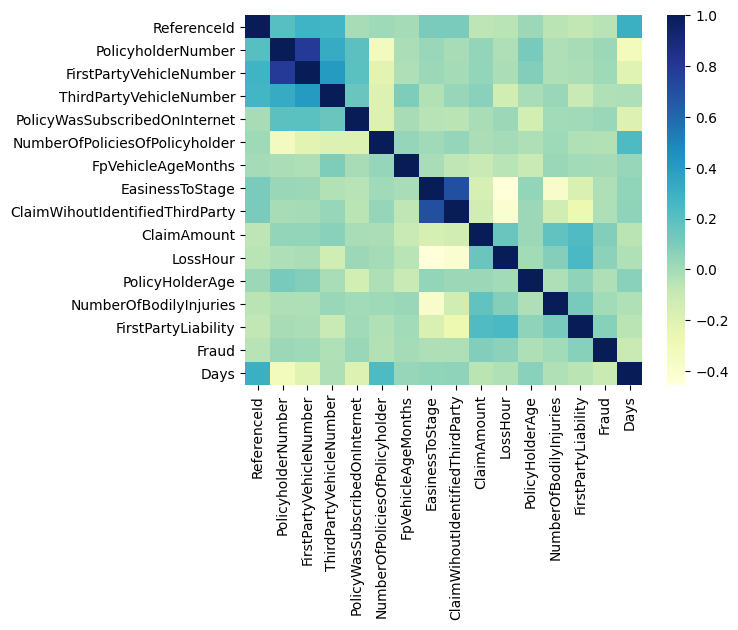

In [22]:
# Checking the correlations via the correlation heatmap
sns.heatmap(df_insurance_claims.corr(numeric_only=True), cmap="YlGnBu")

Correlation between Claimwithoutidentifiedthirdparty and Easinesstostage is high. This is reasonable as during a vehicle crash, it would be strange if the one who claims does not know who involves. Therefore, the crash is likely to be staged. 

Correlation between FirstPartyVehicleNumber and PolicyholderNumber is high which is reasonable as the insurance company might take the Vehicle number as the PolicyholderNumber when they register for insurance. However, this information may not add much value since both of them are unique values (IDs in this case)

In [23]:
# Are the policy numbers unique, or are there any people who filed claims multiple times
def get_uniqueness(df, column_names):
    for column_name in column_names:
        print("{}: Column length: {}, unique values: {}".format(column_name, len(df[column_name]), df[column_name].nunique()))

get_uniqueness(df_insurance_claims, ["PolicyholderNumber"])

# Create a new column with count of claims made by the same policy holder.
# Multiple claims by the same policy holder may likely indicate a fraud.
counts_policy_holder = df_insurance_claims['PolicyholderNumber'].value_counts()
df_insurance_claims["PolicyHolderCount"] = df_insurance_claims["PolicyholderNumber"].map(counts_policy_holder)
df_insurance_claims[["PolicyholderNumber", "PolicyHolderCount"]]

PolicyholderNumber: Column length: 11530, unique values: 9404


,PolicyholderNumber,PolicyHolderCount
0,531112,1
1,87170,2
2,98706,2
3,38240,1
4,11339,4
...,...,...
11525,452486,1
11526,581104,1
11527,817231,1
11528,321534,2


In [24]:
# Column ClaimInvolvedCovers contains a space sepaated list of strings indicating the covers that the individual took
# We convert this into onehot encoded columns
one_hot = pd.get_dummies(df_insurance_claims["ClaimInvolvedCovers"].str.split(" ", expand=True).stack()).groupby(level=0).sum()
df_insurance_claims = pd.concat([df_insurance_claims, one_hot], axis=1)

We decided to drop these columns based on the below main reasons: 
- Those are the unique numbers such as IDs (ReferenceID, PolicyholderNumber, FirstPartyVehicleNumber, ThirdPartyVehicleNumber, InsurerNotes)
- The columns have too many missing values (DamageImportance, ConnectionBetweenParties)
- The values are the postcodes of the addresses (LossPostCode, PolicyHolderPostCode)


In [25]:
# Remove the columns that have too many missing values and unnecessary comlumns such as Reference ID, PolicyHolderPostcode
df_insurance_claims.drop(columns = [
    "ReferenceId",                     # unique 
    "PolicyholderNumber",              # unique
    "FirstPartyVehicleNumber",         # unique    
    "ThirdPartyVehicleNumber",         # unique
    "InsurerNotes",                    # dropping for now
    "DamageImportance",                # too many nans
    #"ConnectionBetweenParties",        # we can fill
    "LossPostCode",                    # not necessary
    "PolicyHolderPostCode",            # not necessary
    # "LossDate",
    # "FirstPolicySubscriptionDate",             
    'ClaimInvolvedCovers'
    ], inplace=True)

In [26]:
# Drop the duplicate rows
df_insurance_claims.drop_duplicates(inplace=True)
df_insurance_claims

,PolicyholderOccupation,LossDate,FirstPolicySubscriptionDate,ClaimCause,FirstPartyVehicleType,ConnectionBetweenParties,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,...,Fire,MaterialDamages,MedicalCare,NaturalCatastrophes,ReplacementVehicle,RiderClothes,Theft,ThirdParty,ThirdPartyMaterialDamages,Windscreen
0,CivilServant,2019-01-02,2018-06-18,CollisionWithAnimal,Car,noconnection,1,1,104.0,0.25,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Worker,2019-01-02,2017-06-29,LossOfControl,Car,noconnection,0,3,230.0,0.50,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Worker,2019-01-02,2017-02-05,AccidentWithIdentifiedThirdParty,Car,noconnection,0,9,93.0,0.25,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CivilServant,2019-01-02,2017-01-21,AccidentWithIdentifiedThirdParty,Car,noconnection,0,2,56.0,0.25,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Farmer,2019-01-02,2018-01-13,AccidentWithIdentifiedThirdParty,Car,noconnection,0,4,110.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11525,Employee,2021-02-17,2019-03-15,WindscreenDamage,Car,noconnection,0,1,85.0,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11526,Employee,2021-03-07,2017-07-20,WindscreenDamage,Car,noconnection,0,3,119.0,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11527,Employee,2021-03-15,2020-09-30,WindscreenDamage,Car,noconnection,0,4,139.0,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11528,CivilServant,2021-03-06,2018-12-28,WindscreenDamage,Car,noconnection,0,6,105.0,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
# Compare the 2 Fraud statuses: 
# sns.pairplot(df_new, hue='Fraud')
# We can see from the plot that the dataset is unbalanced. 

In [28]:
# # get the different column types
# categorical_columns = []
# binary_columns = ["Fraud", "PolicyWasSubscribedOnInternet", "ClaimWithoutIdentifiedThirdParty"]
# numerical_columns = []
# for col in df_insurance_claims.columns:
#     if df_insurance_claims[col].dtype not in ['int64', "float64", "uint8"]:
#         categorical_columns.append(col)
#     else:
#         # not binary data and not previously one-hot encoded
#         if col not in binary_columns and df_insurance_claims[col].dtype != "uint8":
#             numerical_columns.append(col)


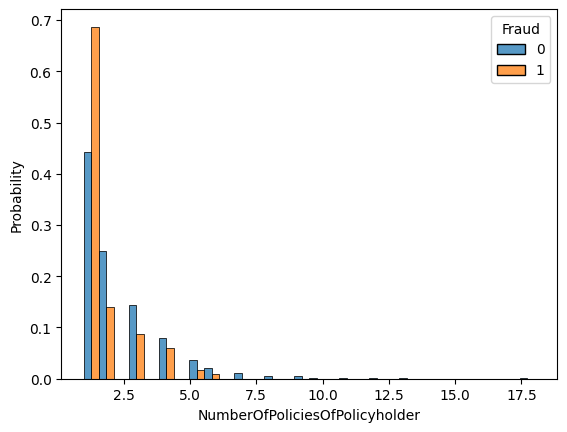

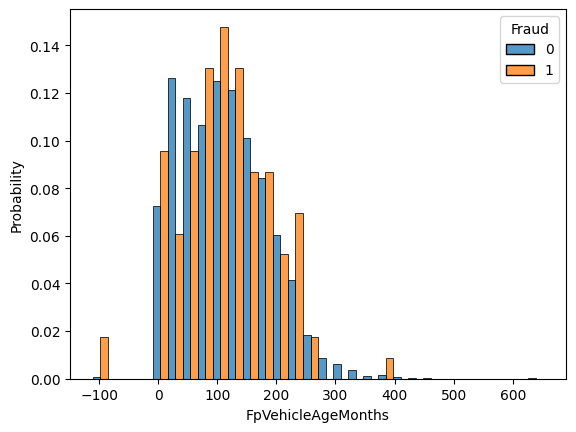

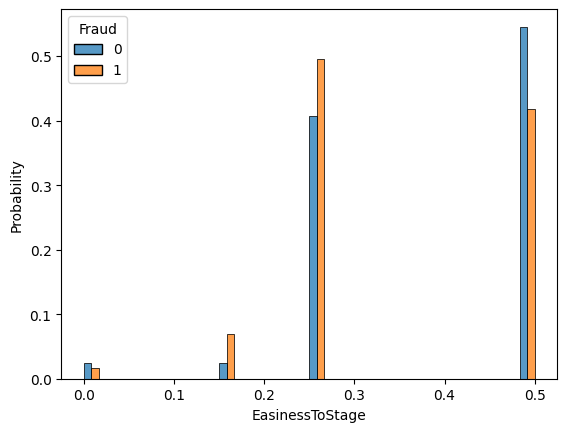

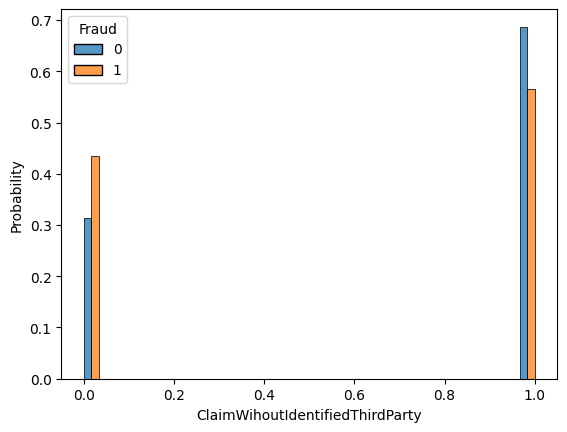

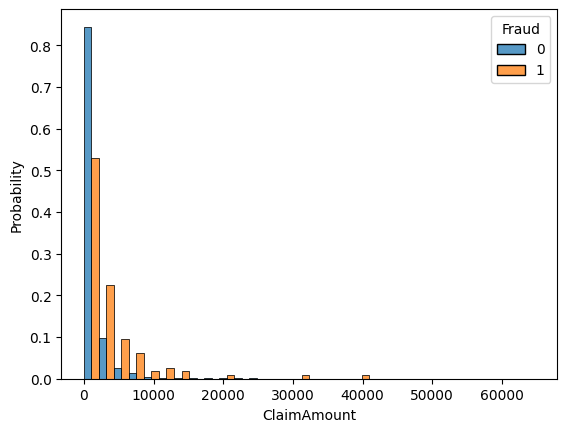

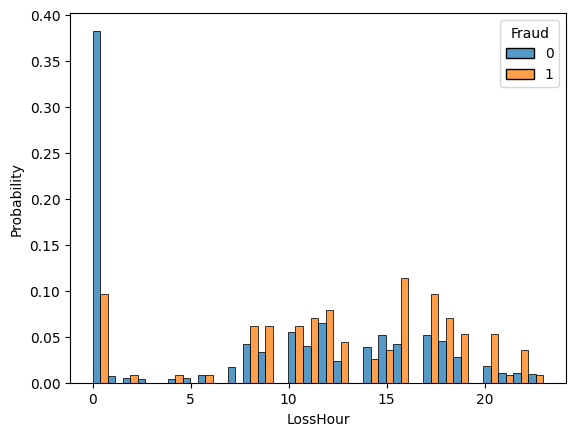

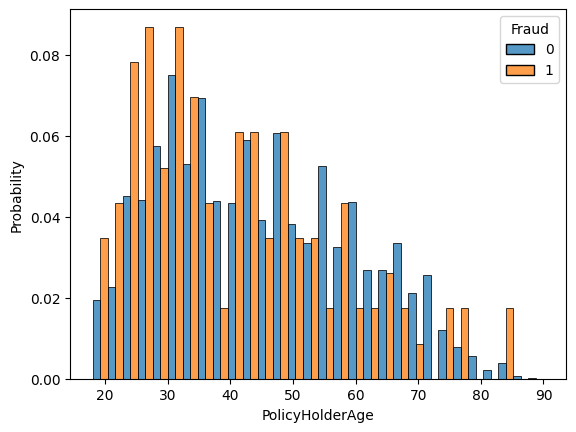

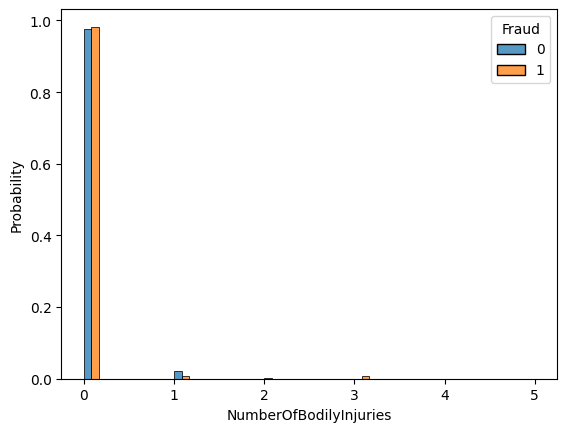

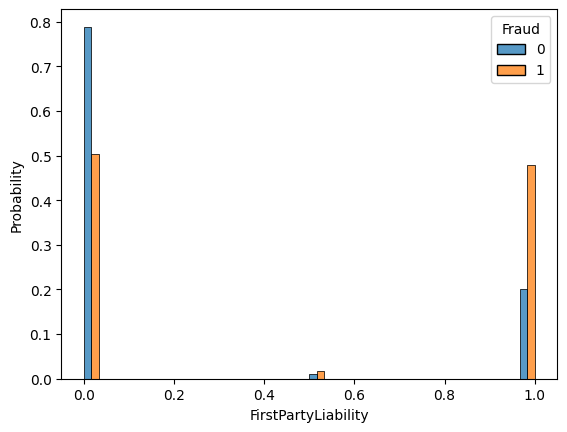

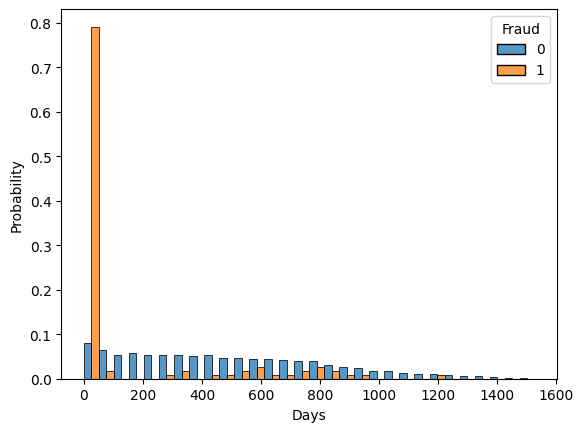

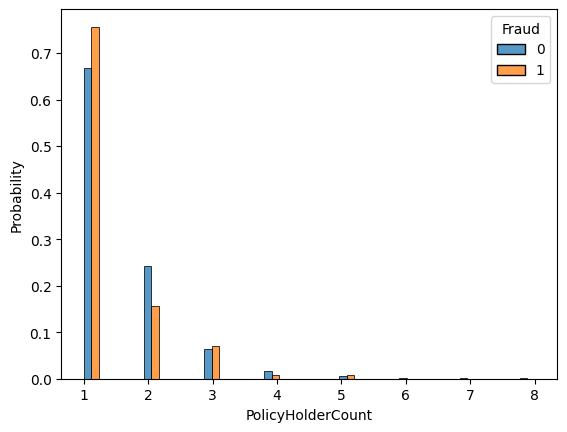

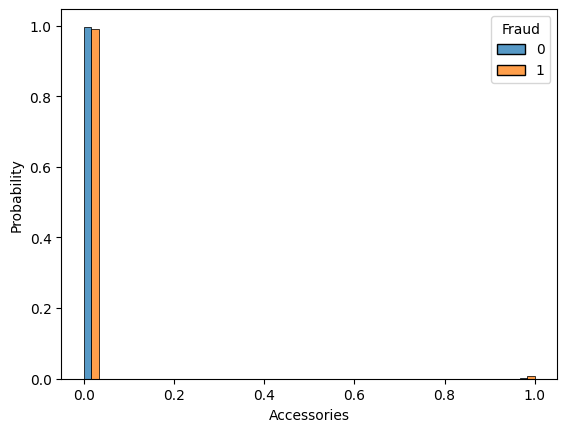

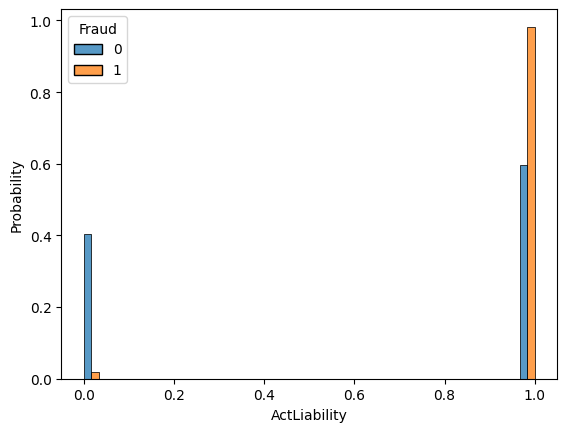

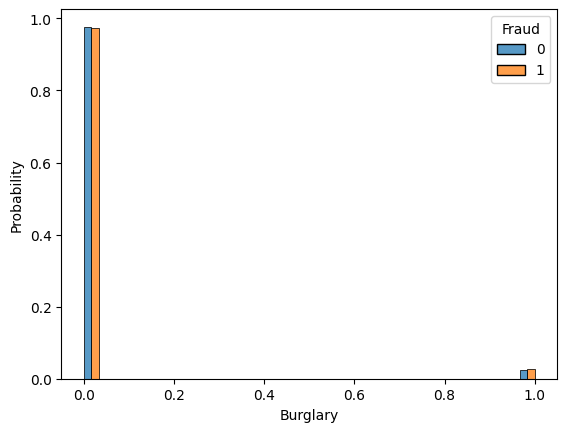

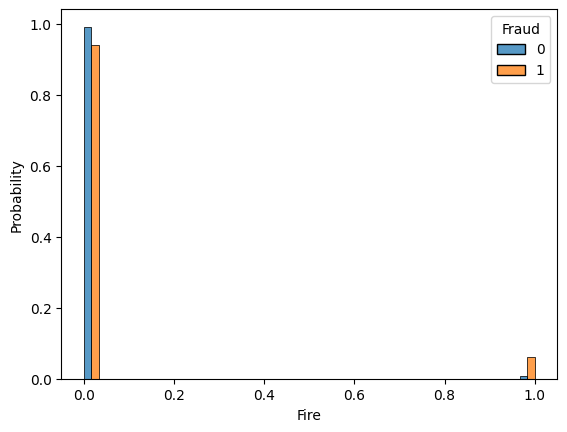

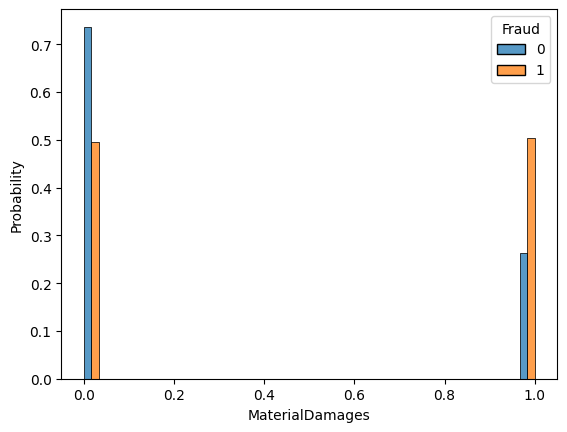

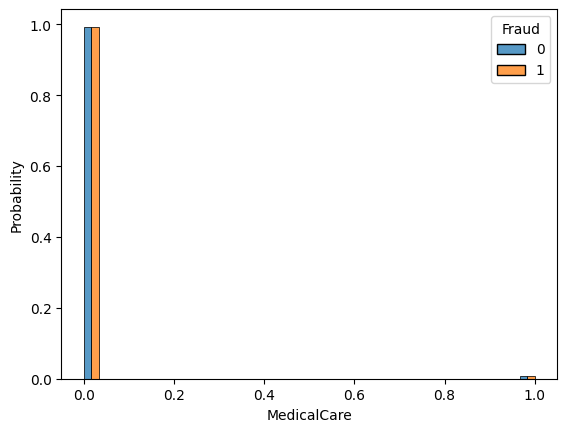

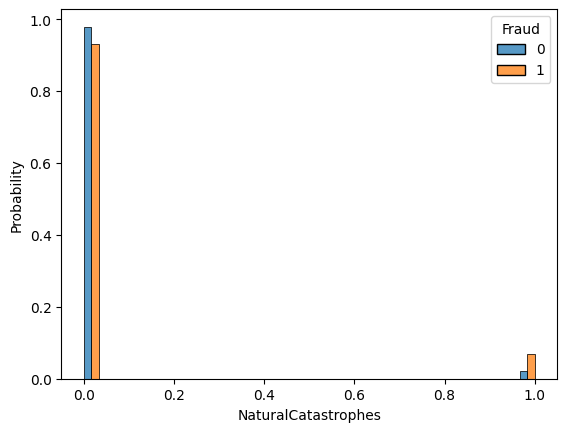

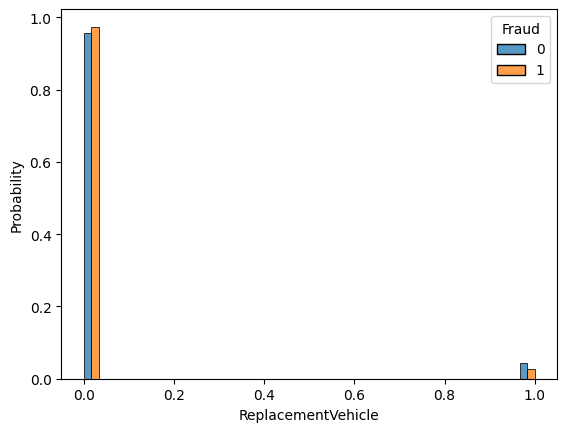

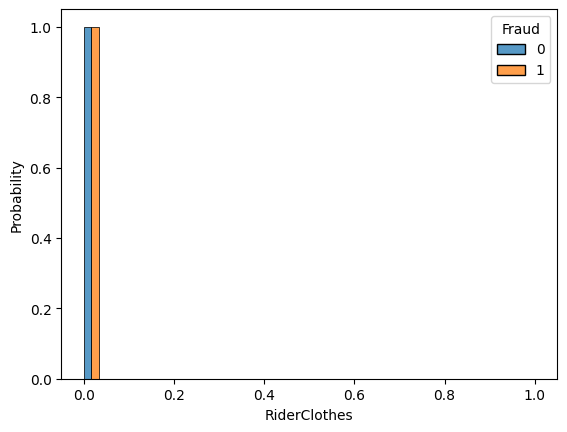

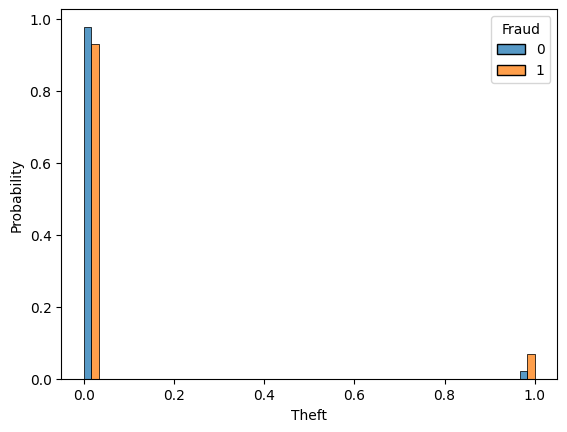

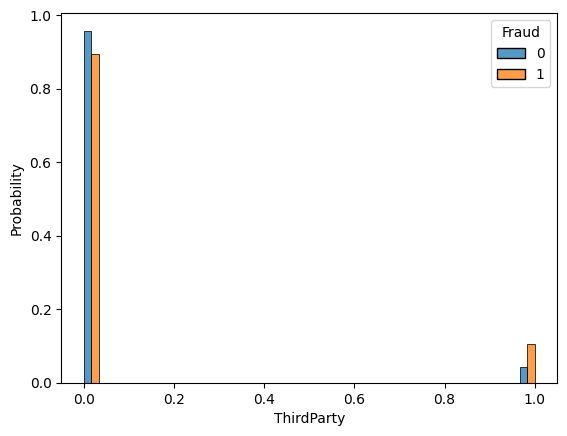

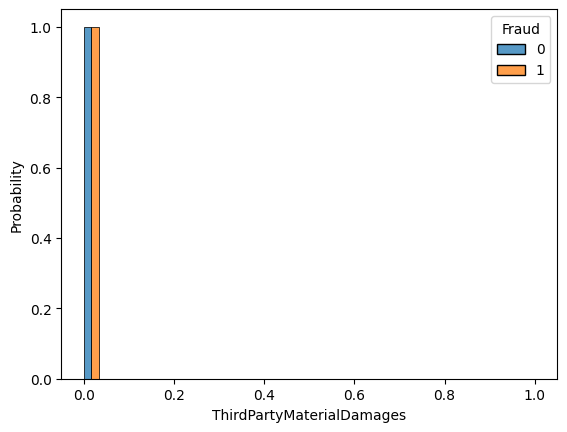

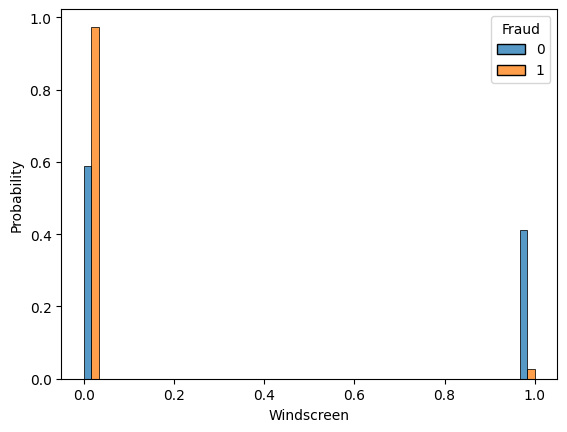

In [29]:
# for col in numerical_columns:
#     sns.histplot(data=df_insurance_claims, x=col, hue='Fraud', multiple='dodge', common_norm=False, stat='probability', bins=30)
#     plt.show()

# Task 3: Model 1

#### For the model 1, we want to find out which claims are suspicious if the incident occurs within t days of subscription date. Therefore, we only need columns:
- FirstPolicySubscriptionDate
- LossDate
- Days
- Fraud

In [30]:
df_insurance_claims_model_1 = df_insurance_claims[["LossDate", "FirstPolicySubscriptionDate", "Fraud", "Days"]]
df_insurance_claims_model_1

,LossDate,FirstPolicySubscriptionDate,Fraud,Days
0,2019-01-02,2018-06-18,0,198
1,2019-01-02,2017-06-29,0,552
2,2019-01-02,2017-02-05,0,696
3,2019-01-02,2017-01-21,0,711
4,2019-01-02,2018-01-13,0,354
...,...,...,...,...
11525,2021-02-17,2019-03-15,0,705
11526,2021-03-07,2017-07-20,0,1326
11527,2021-03-15,2020-09-30,0,166
11528,2021-03-06,2018-12-28,0,799


In [31]:
df_insurance_claims_model_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11516 entries, 0 to 11529
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   LossDate                     11516 non-null  datetime64[ns]
 1   FirstPolicySubscriptionDate  11516 non-null  datetime64[ns]
 2   Fraud                        11516 non-null  int64         
 3   Days                         11516 non-null  int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 449.8 KB


#### Determine the range of the t days

In [32]:
df_fraud = df_insurance_claims_model_1.loc[df_insurance_claims_model_1["Fraud"] == 1]

In [33]:
df_fraud

,LossDate,FirstPolicySubscriptionDate,Fraud,Days
523,2019-02-22,2019-02-22,1,0
653,2019-02-28,2019-02-28,1,0
692,2019-03-06,2019-02-11,1,23
697,2019-03-02,2019-02-28,1,2
772,2019-03-05,2019-02-22,1,11
...,...,...,...,...
9768,2020-10-03,2020-10-01,1,2
10147,2020-11-03,2020-11-01,1,2
10166,2020-11-04,2020-11-02,1,2
10181,2020-10-05,2020-10-05,1,0


In [34]:
# The maximum value of t
df_fraud["Days"].max()

1201

In [35]:
# The minimum value of t
df_fraud["Days"].min()

0

In [36]:
# Set up the range of t days
t = range(1202)

#### We calculated the detection rate and hit rate based on the each t days
- The calculation formula of detection rate is:
$$
  Detection\ Rate =\frac{The\ Number\ of\ Detection}{Total\ Number\ of\ Observation}\, *100\%
$$
- The calculation formula of hit rate is:
$$
  Hit\ Rate =\frac{The\ Number\ of\ Real\ Fraud}{The\ Number\ of\ Detection}\, *100\%
$$


In [37]:
def detect_fraudulent_claims_model_1(day_thresholds_to_check, df_datasets):
    
    # All_detection rate
    detection_rates = []
    # All hit rate
    hit_rates = []
    # All predictions 
    all_predictions = []
    
    for day_threshold in day_thresholds_to_check:
        # All prediction based on each t
        current_predictions = []
        # The number of detection
        suspicion_count = 0
        # The number of real fraud
        true_fraud_count = 0
        
        for row_index in range(len(df_datasets)):
            # Flag as fraud if the number of days since activation is less than the threshold
            if df_datasets["Days"][row_index] <= day_threshold:
                suspicion_count = suspicion_count + 1
                current_predictions.append(1)

                if df_datasets["Fraud"][row_index] == 1:
                    true_fraud_count = true_fraud_count + 1

            else:
                current_predictions.append(0)
        
        detection_rate = round((suspicion_count / len(df_datasets))*100, 2)
        detection_rates.append(detection_rate)
        
        hit_rate = round((true_fraud_count / suspicion_count)*100, 2)
        hit_rates.append(hit_rate)
        
        all_predictions.append(current_predictions)

    
    return detection_rates, hit_rates, all_predictions

In [38]:
d, h, Y_all_prediction = detect_fraudulent_claims_model_1(t, df_insurance_claims_model_1.reset_index(drop=True))

### The hit rate and detection rate of this model for different values of t are:

Text(0, 0.5, 'Hit Rate')

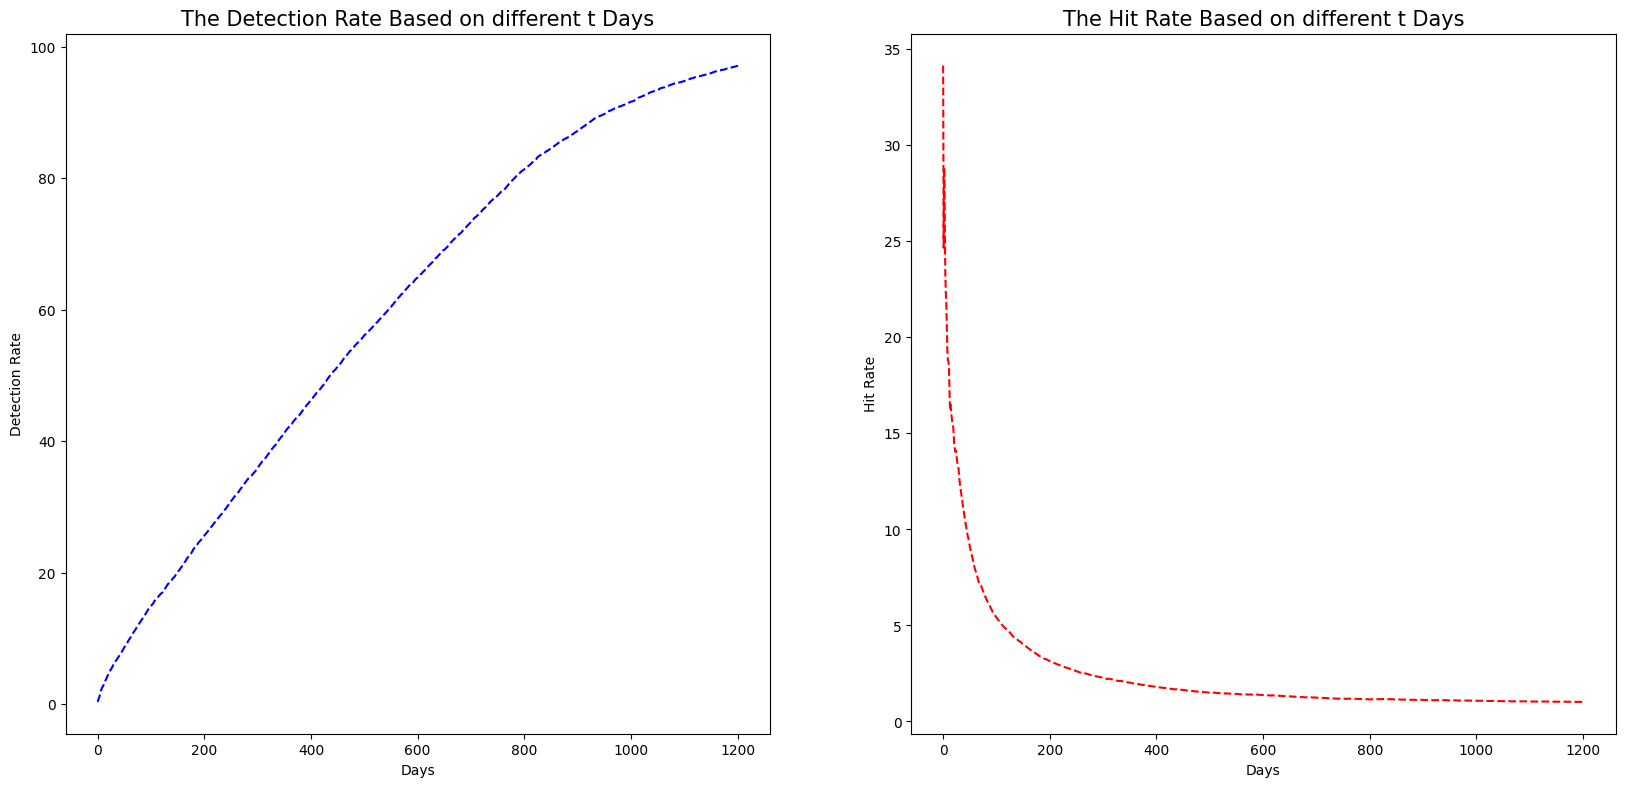

In [39]:
### Plot the results of detection rate and hit rate
fig = plt.figure(figsize = (20, 20))
AX1 = fig.add_subplot(2,2,1)
AX2 = fig.add_subplot(2,2,2)

AX1.plot(t, d, ls = "--", color = "blue")
AX2.plot(t, h, ls = "--", color = "red")

AX1.set_title("The Detection Rate Based on different t Days", fontsize = 15, horizontalalignment="center")
AX2.set_title("The Hit Rate Based on different t Days", fontsize = 15, horizontalalignment="center")

AX1.set_xlabel("Days", fontsize = 10)
AX1.set_ylabel("Detection Rate", fontsize = 10)

AX2.set_xlabel("Days", fontsize = 10)
AX2.set_ylabel("Hit Rate", fontsize = 10)

In order to choose a sensible value of t, we used AUC to evaluate which t is the sensible one. 

A large AUC indicates that this model with a specific t is able to accurately identify suspicious claims while minimizing the number of false positives.


In [40]:
def get_all_auc(y, y_hat):
    all_auc = []
    for i in range(len(y_hat)):
        roc_acc = round(metrics.roc_auc_score(y, y_hat[i]), 2)
        all_auc.append(roc_acc)
    return all_auc

In [41]:
all_auc = get_all_auc(df_insurance_claims_model_1["Fraud"], Y_all_prediction)

Text(0, 0.5, 'AUC')

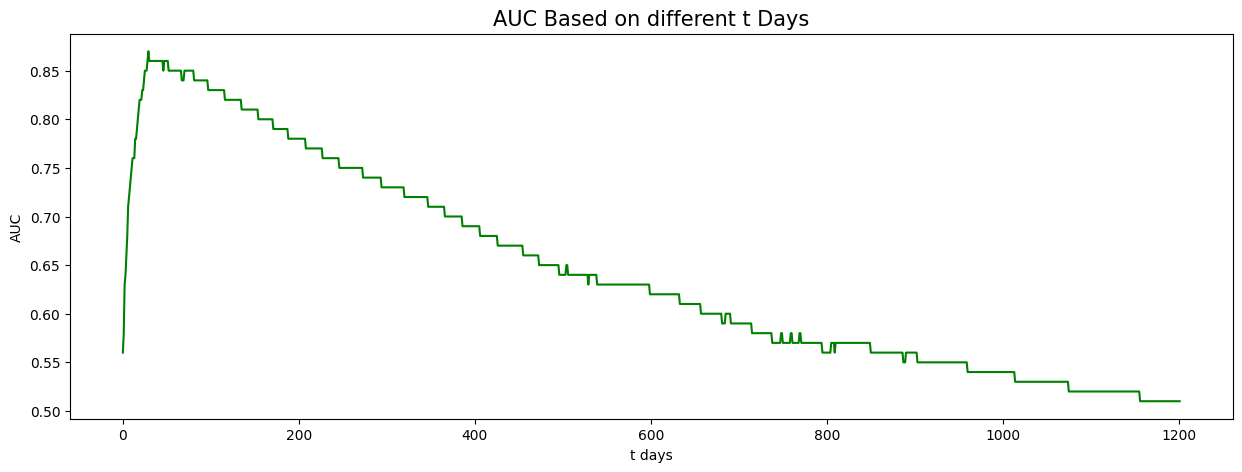

In [42]:
### Plot AUC based on each t days
fig = plt.figure(figsize = (15, 5))
AX1 = fig.add_subplot(1,1,1)

AX1.plot(t, all_auc, ls = "-", color = "green")

AX1.set_title("AUC Based on different t Days", fontsize = 15, horizontalalignment="center")

AX1.set_xlabel("t days", fontsize = 10)
AX1.set_ylabel("AUC", fontsize = 10)


In [43]:
### Find out the sensible t of this model
for i in range(len(all_auc)):
    if all_auc[i] == max(all_auc):
        print("The sensible t is " + str(i))
        print("The detection rate is " + str(d[i]) + "%")
        print("The hit rate is " + str(h[i]) + "%")
        print("The AUC of the model is " + str(all_auc[i]))

        break

auc_heuristic = all_auc[i]

The sensible t is 29
The detection rate is 5.94%
The hit rate is 13.16%
The AUC of the model is 0.87


### The logic underlies this model and its bias
The logic underlying this model is that when a customer subscribes to a service, it is more likely that fraudulent claims will be made shortly after the subscription date. Therefore, by setting a threshold for how soon a claim can be made after the subscription date, it is possible to identify suspicious claims. This threshold can then be adjusted to find a balance between the hit rate and detection rate for the model.


However, this model has the potential to discriminate against customers who make claims shortly after subscribing to a service, as these claims will be flagged as suspicious regardless of their validity. That would damage the customers' trust relationship with the company. Additionally, if the threshold is set too low, then the model may also falsely flag legitimate claims as suspicious.

### Choose the best model performance based on F1 score

Here we chose both AUC score and F1 score as the metric to evaluate the model. Because the dataset is extremely imbalanced i.e. only one precent of the instances are positive, accuracy is not an ideal metric, if we predict all the outcome to be negative, the model will still have an accuracy rate close to 99%. 


AUC calculates the area under the ROC curve, a large amount of area would show that the model can achieve a high true positive rate with a correspondingly low false positive rate. 


F1 score is the harmonic mean of recall and precision, it is particularly useful when both false positive rate and false negative rate are important which is true in our case. We would like to lower fase positive rate to reach a high hit rate, meanwhile we would also to keep the false negative rate low because our ultimate goal is to spot as many fraudulant cases as possible.

In [44]:
# Define function to get F1 score
def get_all_F1_score(y, y_hat):
    F1_score = []
    for i in range(len(y_hat)):
        F1 = round(metrics.f1_score(y, y_hat[i]), 2)
        F1_score.append(F1)
    return F1_score

In [45]:
all_F1_score = get_all_F1_score(df_insurance_claims_model_1["Fraud"], Y_all_prediction)

Text(0, 0.5, 'F1 score')

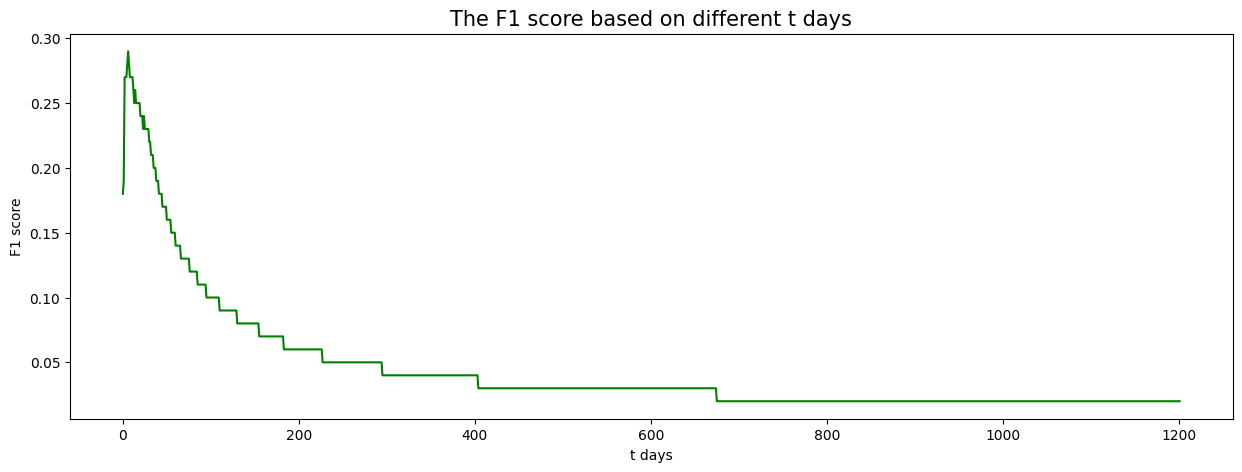

In [46]:
### Plot the F1 score based on each t days
fig = plt.figure(figsize = (15, 5))
AX1 = fig.add_subplot(1,1,1)

AX1.plot(t, all_F1_score, ls = "-", color = "green")

AX1.set_title("The F1 score based on different t days", fontsize = 15, horizontalalignment="center")

AX1.set_xlabel("t days", fontsize = 10)
AX1.set_ylabel("F1 score", fontsize = 10)


In [47]:
### Find out the sensible t of this model
for i in range(len(all_F1_score)):
    if all_F1_score[i] == max(all_F1_score):
        print("The sensible t is " + str(i))
        print("The detection rate is " + str(d[i]) + "%")
        print("The hit rate is " + str(h[i]) + "%")
        print("The F1 score of the model is " + str(all_F1_score[i]))

        break

f1_heuristic = all_F1_score[i]

The sensible t is 6
The detection rate is 2.04%
The hit rate is 21.7%
The F1 score of the model is 0.29


# Task 4
# Model 2: Decision Tree

In [48]:
# Remove the columns that have too many missing values and unnecessary comlumns such as Reference ID, PolicyHolderPostcode
df_insurance_claims.drop(columns=["LossDate", "FirstPolicySubscriptionDate"], inplace=True)

In [49]:
# Removing the mising values
df_insurance_claims_clean = df_insurance_claims[
    (df_insurance_claims.PolicyholderOccupation.notnull()) &
    (df_insurance_claims.ClaimCause.notnull()) &
    # (df_insurance_claims.ClaimInvolvedCovers.notnull()) &
    (df_insurance_claims.FirstPartyVehicleType.notnull()) &
    (df_insurance_claims.FpVehicleAgeMonths.notnull()) &
    (df_insurance_claims.LossHour.notnull()) &
    (df_insurance_claims.PolicyHolderAge.notnull())
].reset_index(drop=True)

In [50]:
df_insurance_claims_clean.head()


,PolicyholderOccupation,ClaimCause,FirstPartyVehicleType,ConnectionBetweenParties,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,...,Fire,MaterialDamages,MedicalCare,NaturalCatastrophes,ReplacementVehicle,RiderClothes,Theft,ThirdParty,ThirdPartyMaterialDamages,Windscreen
0,CivilServant,CollisionWithAnimal,Car,noconnection,1,1,104.0,0.25,1,4624.73,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Worker,LossOfControl,Car,noconnection,0,3,230.0,0.50,1,1606.81,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Worker,AccidentWithIdentifiedThirdParty,Car,noconnection,0,9,93.0,0.25,0,998.20,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CivilServant,AccidentWithIdentifiedThirdParty,Car,noconnection,0,2,56.0,0.25,0,2506.92,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Farmer,AccidentWithIdentifiedThirdParty,Car,noconnection,0,4,110.0,0.25,0,12.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# Check the datatype of each column
df_insurance_claims_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10890 entries, 0 to 10889
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PolicyholderOccupation           10890 non-null  object 
 1   ClaimCause                       10890 non-null  object 
 2   FirstPartyVehicleType            10890 non-null  object 
 3   ConnectionBetweenParties         10890 non-null  object 
 4   PolicyWasSubscribedOnInternet    10890 non-null  int64  
 5   NumberOfPoliciesOfPolicyholder   10890 non-null  int64  
 6   FpVehicleAgeMonths               10890 non-null  float64
 7   EasinessToStage                  10890 non-null  float64
 8   ClaimWihoutIdentifiedThirdParty  10890 non-null  int64  
 9   ClaimAmount                      10890 non-null  float64
 10  LossHour                         10890 non-null  float64
 11  PolicyHolderAge                  10890 non-null  float64
 12  NumberOfBodilyInju

In [52]:
# Check categorical data
df_insurance_claims_clean[["PolicyholderOccupation","ClaimCause", "FirstPartyVehicleType"]]

,PolicyholderOccupation,ClaimCause,FirstPartyVehicleType
0,CivilServant,CollisionWithAnimal,Car
1,Worker,LossOfControl,Car
2,Worker,AccidentWithIdentifiedThirdParty,Car
3,CivilServant,AccidentWithIdentifiedThirdParty,Car
4,Farmer,AccidentWithIdentifiedThirdParty,Car
...,...,...,...
10885,Employee,WindscreenDamage,Car
10886,Employee,WindscreenDamage,Car
10887,Employee,WindscreenDamage,Car
10888,CivilServant,WindscreenDamage,Car


In [53]:
# Get dummy variables for categorical data
df_insurance_claims_clean = pd.get_dummies(df_insurance_claims_clean , drop_first=True, columns=["PolicyholderOccupation","ClaimCause","FirstPartyVehicleType", "ConnectionBetweenParties"])
df_insurance_claims_clean = df_insurance_claims_clean.dropna()
df_insurance_claims_clean

,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,...,ClaimCause_Vandalism,ClaimCause_WindscreenDamage,FirstPartyVehicleType_Caravan,FirstPartyVehicleType_Motorcycle,FirstPartyVehicleType_PrivateCar,ConnectionBetweenParties_SameBankAccount,ConnectionBetweenParties_SameEmail,ConnectionBetweenParties_SamePhone,ConnectionBetweenParties_SamePolice,ConnectionBetweenParties_noconnection
0,1,1,104.0,0.25,1,4624.73,8.0,45.0,0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,0,3,230.0,0.50,1,1606.81,11.0,20.0,0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,0,9,93.0,0.25,0,998.20,18.0,32.0,0,0.5,...,0,0,0,0,0,0,0,0,0,1
3,0,2,56.0,0.25,0,2506.92,11.0,46.0,0,0.5,...,0,0,0,0,0,0,0,0,0,1
4,0,4,110.0,0.25,0,12.00,12.0,28.0,0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10885,0,1,85.0,0.50,1,1010.23,0.0,56.0,0,0.0,...,0,1,0,0,0,0,0,0,0,1
10886,0,3,119.0,0.50,1,154.35,0.0,54.0,0,0.0,...,0,1,0,0,0,0,0,0,0,1
10887,0,4,139.0,0.50,1,420.25,0.0,34.0,0,0.0,...,0,1,0,0,0,0,0,0,0,1
10888,0,6,105.0,0.50,1,96.40,0.0,58.0,0,0.0,...,0,1,0,0,0,0,0,0,0,1


Modelling

In [54]:
def grid_search(model, parameters, X_train, X_valid, y_train, y_valid, primary_metric='roc_auc'):
    # Find the best combination of model parameters using cross validation
    clf = GridSearchCV(
        model, 
        parameters,
        cv=3,
        scoring=['neg_log_loss', 'precision', 'roc_auc', 'accuracy'],
        refit=primary_metric,
    )

    clf = clf.fit(X_train, y_train)

    print('best_params: ', clf.best_params_)

    # Evaluate the model's metrics
    print('--CROSS VALIDATION--')
    print('precision:', np.round(clf.cv_results_['mean_test_precision'][clf.best_index_], 3))
    print('roc_auc:', np.round(clf.cv_results_['mean_test_roc_auc'][clf.best_index_], 3))
    print('log_loss:', -np.round(clf.cv_results_['mean_test_neg_log_loss'][clf.best_index_], 3))
    print('accuracy:', np.round(clf.cv_results_['mean_test_accuracy'][clf.best_index_], 3))
    
    print('--VALIDATION--')
    y_pred_valid = clf.predict(X_valid)
    y_pred_valid_prob = clf.predict_proba(X_valid)[:, 1]
    print('precision:', np.round(precision_score(y_valid, y_pred_valid), 3))
    print('roc_auc:', np.round(roc_auc_score(y_valid, y_pred_valid_prob), 3))
    print('log_loss:', np.round(log_loss(y_valid, y_pred_valid_prob), 3))
    print('accuracy:', np.round(accuracy_score(y_valid, y_pred_valid), 3))

    return clf

In [55]:
X = df_insurance_claims_clean.drop(columns = ["Fraud"], axis=1)
y = df_insurance_claims_clean["Fraud"]

In [56]:
# Separate the data into training/validation/testing with percentages 60%/20%/20%
X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.6, random_state=242)
X_test, X_valid, y_test, y_valid = train_test_split(X_other, y_other, train_size = 0.5, random_state=135)

print(f'Training on {len(X_train)} observations, validating on {len(X_valid)} and testing on {len(X_test)} observations')
print('Number of features:', len(X_train.columns))

Training on 6533 observations, validating on 2178 and testing on 2178 observations
Number of features: 60


In [57]:
# Fit the model
# To prevent the model from classifying everything as negative, we used the balanced class weight
model = DecisionTreeClassifier(random_state=345)

parameters = {
    'max_depth': [3, 4, 5, 6, 7, 10, None],
    'min_samples_split': [0.05, 0.1, 0.2],
    'class_weight': ['balanced']
}

clf = grid_search(model, parameters, X_train, X_valid, y_train, y_valid)

best_params:  {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 0.05}
--CROSS VALIDATION--
precision: 0.132
roc_auc: 0.944
log_loss: 0.18
accuracy: 0.933
--VALIDATION--
precision: 0.132
roc_auc: 0.934
log_loss: 0.181
accuracy: 0.939


precision: 0.094
roc_auc: 0.913
log_loss: 0.242
accuracy: 0.924
recall: 0.895
f1 score: 0.171


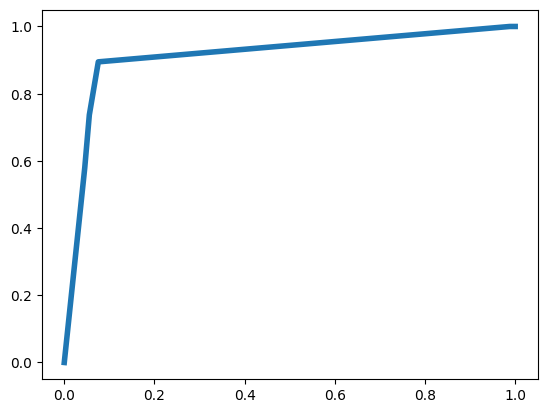

In [58]:
# retrain the model
trainX_final=pd.concat([X_train, X_valid])
trainY_final=pd.concat([y_train, y_valid])
best_model = DecisionTreeClassifier(**clf.best_params_).fit(trainX_final, trainY_final)
y_pred_test = best_model.predict(X_test)
y_pred_test_prob = best_model.predict_proba(X_test)[:, 1]

print('precision:', np.round(precision_score(y_test, y_pred_test), 3))
print('roc_auc:', np.round(roc_auc_score(y_test, y_pred_test_prob), 3))
print('log_loss:', np.round(log_loss(y_test, y_pred_test_prob), 3))
print('accuracy:', np.round(accuracy_score(y_test, y_pred_test), 3))
print('recall:', np.round(recall_score(y_test, y_pred_test), 3))
print('f1 score:', np.round(f1_score(y_test, y_pred_test), 3))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob)
plt.plot(fpr, tpr, linewidth=4)
plt.show()

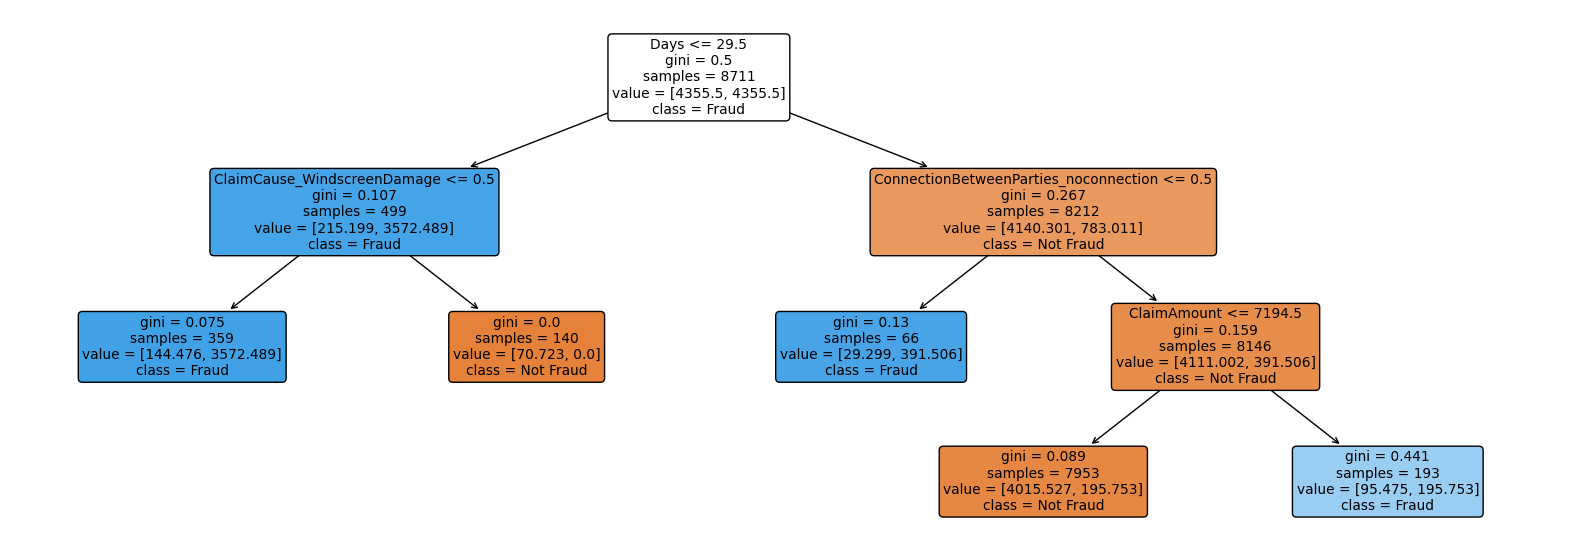

In [59]:
# Plot the tree
plt.figure(figsize=(20, 7))
plot_tree(best_model, feature_names=X_train.columns, filled=True, rounded=True, class_names=["Not Fraud","Fraud"])
plt.show()


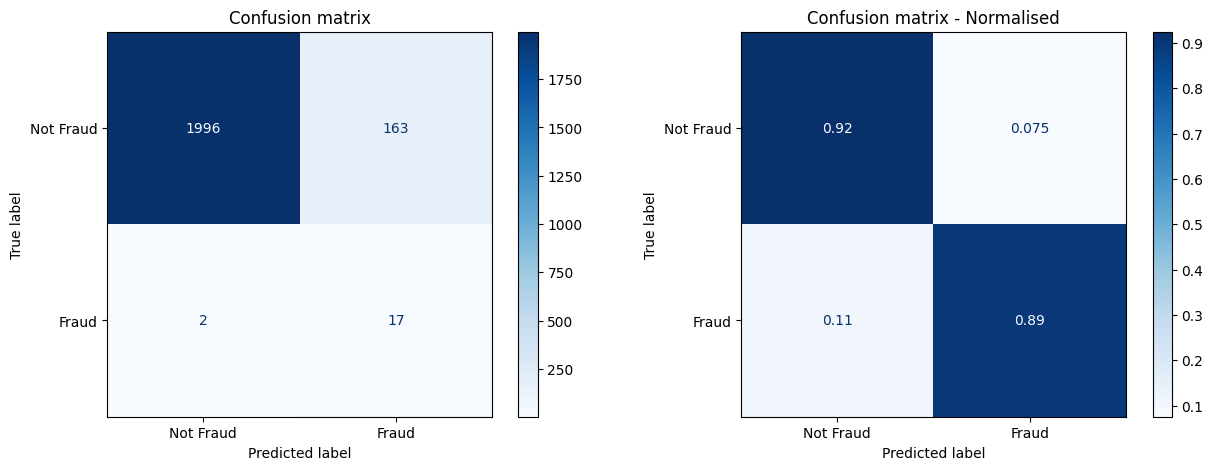

In [60]:
# Confusion matrix
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.from_predictions(y_test, y_pred_test, normalize=None, ax=axs[0], display_labels=['Not Fraud', 'Fraud'], cmap='Blues')
axs[0].set_title('Confusion matrix')
disp.from_predictions(y_test, y_pred_test, normalize='true', ax=axs[1], display_labels=['Not Fraud', 'Fraud'], cmap='Blues')
axs[1].set_title('Confusion matrix - Normalised')
plt.show()

In [61]:
# Final model
X_final = pd.concat([X_train, X_test], ignore_index=True)
y_final = pd.concat([y_train, y_test], ignore_index=True)

final_model = DecisionTreeClassifier(**clf.best_params_, random_state=42).fit(X_final, y_final)

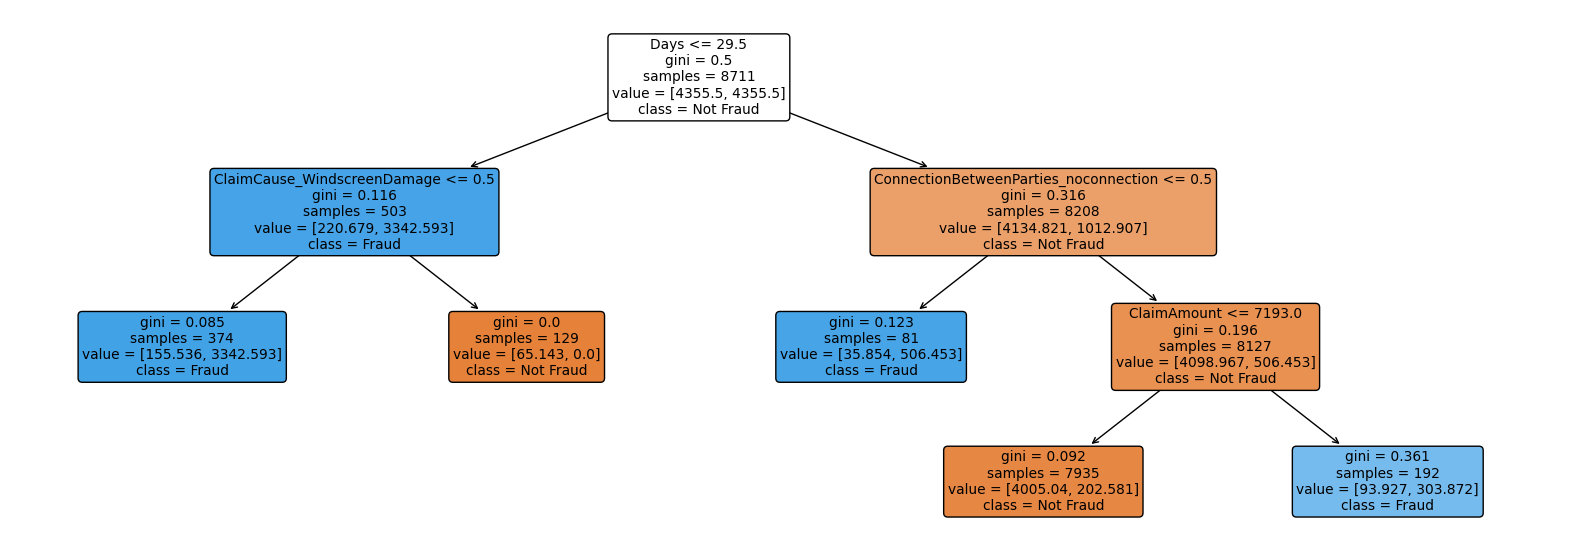

In [62]:
# Plot the final Decision tree model after retraining
plt.figure(figsize=(20, 7))
plot_tree(final_model, feature_names=X_train.columns, filled=True, rounded=True, class_names=["Not Fraud","Fraud"])
plt.show()

Calculate the detection rates and hit rates

In [63]:
a = 0
b = 0
for i, o in zip(y_test, y_pred_test):
    if o == 1:
        a += 1
    if i == 1 & o == 1:
        b += 1

Decision_Tree_d = round((a / len(y_pred_test))*100, 2)
Decision_Tree_h = round((b / a)*100, 2)
        

In [148]:
Decision_Tree_d

8.26

In [65]:
Decision_Tree_h

9.44

In [66]:
auc_dt = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])
auc_dt

0.9125691718875699

In [67]:
f1_dt = np.round(f1_score(y_test, y_pred_test), 3)
f1_dt

0.171

In [68]:
df_result = pd.DataFrame({"y_hat": y_pred_test,
                          "y": y_test})

df_result.to_csv("dt_result.csv")

### We decided to build a more complicated model, Random Forest particularly, to see if we can improve the performance of the Decision Tree Model.

The Random Forest Model has the ability to outperform the Decision Tree Model by limiting overfitting without substantially increasing error due to bias.

## Model 3: Random Forest

In [69]:
# import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [70]:
# Define parameters 
parameters = {
    'n_estimators': randint(100, 200),
    'max_depth': randint(5, 15),
    'class_weight': ['balanced']
}

# Create a random forest classifier
rf = RandomForestClassifier(random_state=135)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(
    rf, 
    param_distributions = parameters, 
    n_iter=40, 
    cv=3,
    random_state=120,
    scoring='roc_auc'
)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=135),
                   n_iter=40,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8b698a93c0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8b698a9240>},
                   random_state=120, scoring='roc_auc')

In [71]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 197}


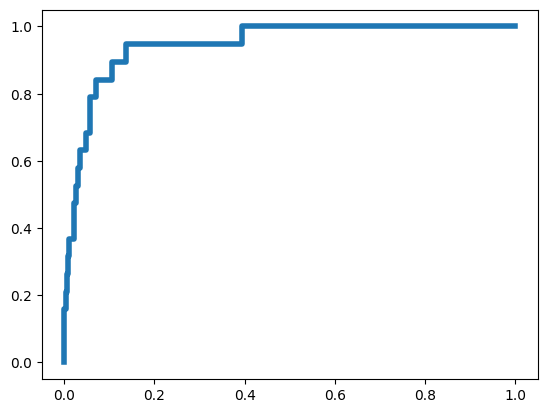

In [72]:
# retrain the model using the best params
trainX_final = pd.concat([X_train, X_valid])
trainY_final = pd.concat([y_train, y_valid])
best_rf = RandomForestClassifier(random_state=135, **rand_search.best_params_).fit(trainX_final, trainY_final)

# Generate predictions with the best model
rf_y_pred = best_rf.predict(X_test)
rf_y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, rf_y_pred_prob)
plt.plot(fpr, tpr, linewidth=4)
plt.show()

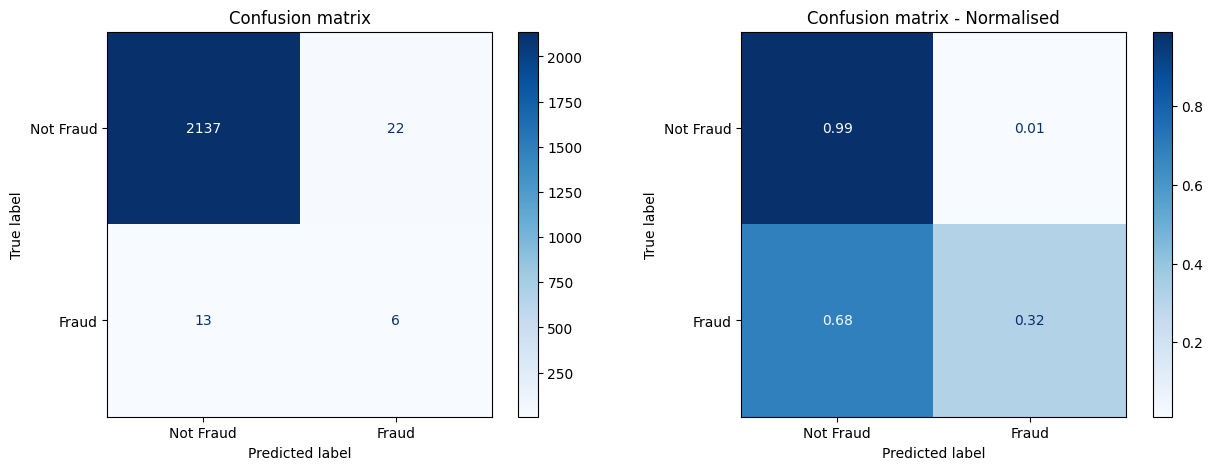

In [73]:
# Confusion matrix
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
cm = confusion_matrix(y_test, rf_y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.from_predictions(y_test, rf_y_pred, normalize=None, ax=axs[0], display_labels=['Not Fraud', 'Fraud'], cmap='Blues')
axs[0].set_title('Confusion matrix')
disp.from_predictions(y_test, rf_y_pred, normalize='true', ax=axs[1], display_labels=['Not Fraud', 'Fraud'], cmap='Blues')
axs[1].set_title('Confusion matrix - Normalised')
plt.show()

In [74]:
# Calculate the performance metrics
print('roc_auc:', np.round(roc_auc_score(y_test, rf_y_pred_prob), 3))
print('recall:', np.round(recall_score(y_test, rf_y_pred), 3))
print('f1 score:', np.round(f1_score(y_test, rf_y_pred), 3))
print("Accuracy:", np.round(accuracy_score(y_test, rf_y_pred), 3))
print("Precision:", np.round(precision_score(y_test, rf_y_pred), 3))


roc_auc: 0.946
recall: 0.316
f1 score: 0.255
Accuracy: 0.984
Precision: 0.214


Calculate the hit rates and detection rates

In [75]:
a = 0
b = 0
for i, o in zip(y_test, rf_y_pred):
    if o == 1:
        a += 1
    if i == 1 & o == 1:
        b += 1

RF_d = round((a / len(rf_y_pred))*100, 2)
RF_h = round((b / a)*100, 2)

In [76]:
RF_h

21.43

In [77]:
RF_d

1.29

In [78]:
auc_rf = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
auc_rf

0.9456863557689963

In [79]:
f1_rf = np.round(f1_score(y_test, rf_y_pred), 3)
f1_rf

0.255

In [80]:
rf_result = pd.DataFrame({"y_hat": rf_y_pred,
                          "y": y_test})

rf_result.to_csv("rf_result.csv")

In [81]:
# Compare the detection rates and hit rates of the first 3 Models
model_performance = pd.DataFrame(
    {
        'model': ['Heuristic Model', 'Decision Tree Model', 'Random Forest Model'],
        'detection rate': [d[29], Decision_Tree_d, RF_d],
        'hit rate': [h[29], Decision_Tree_h, RF_h],
        'auc': [auc_heuristic, auc_dt, auc_rf],
        'f1_score': [f1_heuristic, f1_dt, f1_rf]
    }
).round(2)

model_performance

,model,detection rate,hit rate,auc,f1_score
0,Heuristic Model,5.94,13.16,0.87,0.29
1,Decision Tree Model,8.26,9.44,0.91,0.17
2,Random Forest Model,1.29,21.43,0.95,0.26


From the comparison above, it can be seen that:
- Decision Tree model is the most "aggressive" model. It has the highest detection rate but lowest hit rate. It flags the highest number of suspicious cases that turn out to be not fraud.
- Random Forest model is the least "aggressive" one - its detection rate is significantly lower than others' but the hit rate is significantly higher, which means its fraud prediction is more reliable.  If this model is implemented, it will result in the least number of false alarms which can be helpful in maintaining trust relationship with customers.
- If we consider AUC as the main metric of model success, the Random Forest Model has the highest AUC, followed by the Decision Tree Model and the last one is the Heuristic Model

We continue to build the Neural Network model in the next parts to see if it can outperform the three mentioned models. 

## Task 5: Model 4 - The Neural Network Model

In [82]:
df_insurance_claims_model_4 = df_insurance_claims_clean.reset_index(drop=True)

#### Build the Neural Network Model

In [116]:
tf.keras.backend.clear_session()
np.random.seed(312)
tf.random.set_seed(111)

In [117]:
# Standardize the input data value into a standard format
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [118]:
def neural_network_model(hp):
    num_units = hp.Choice('num_units', [64, 128]) 
    # dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value = 0.3)
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value = 0.3, sampling = 'log')
    # optimizer_algorithm = hp.Choice('optimizer', values=['sgd','adam']) 
    # if optimizer_algorithm == 'sgd':
    #     optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,clipvalue=1)
    # elif optimizer_algorithm == 'adam':
    #     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.models.Sequential([
        # tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy', #loss function, the result is binary
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
                
    return model

In [119]:
# Find the optimal parameters for the model
tuner = kt.Hyperband(neural_network_model,
                     objective='val_loss',
                     max_epochs=20,
                     factor=3,
                     directory='logs',
                     project_name='Nlll',
                     overwrite=True)

In [120]:
tuner.search(X_train, y_train, validation_data=(X_valid,y_valid))

Trial 30 Complete [00h 00m 26s]
val_loss: 0.045901451259851456

Best val_loss So Far: 0.044758059084415436
Total elapsed time: 00h 05m 46s
INFO:tensorflow:Oracle triggered exit


In [122]:
best_hps = tuner.get_best_hyperparameters()[0]
print("Best number of hidden units:", best_hps['num_units'])
# print("Best dropout rate:", best_hps['dropout_rate'])
print("Best learning rate:", best_hps['learning_rate'])


Best number of hidden units: 128
Best learning rate: 0.05267860855836106


In [123]:
best_model = tuner.hypermodel.build(best_hps)

In [124]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [125]:
log = best_model.fit(X_train, y_train, epochs=30, batch_size = 64, validation_data=(X_valid,y_valid), callbacks=[early_stopping_cb])

Epoch 1/30
103/103 [==============================] - 3s 8ms/step - loss: 0.1312 - accuracy: 0.9637 - auc_1: 0.6628 - val_loss: 0.0483 - val_accuracy: 0.9885 - val_auc_1: 0.8575
Epoch 2/30
103/103 [==============================] - 1s 5ms/step - loss: 0.0450 - accuracy: 0.9894 - auc_1: 0.8729 - val_loss: 0.0549 - val_accuracy: 0.9899 - val_auc_1: 0.7669
Epoch 3/30
103/103 [==============================] - 1s 5ms/step - loss: 0.0423 - accuracy: 0.9897 - auc_1: 0.8945 - val_loss: 0.0614 - val_accuracy: 0.9899 - val_auc_1: 0.7696
Epoch 4/30
103/103 [==============================] - 1s 5ms/step - loss: 0.0415 - accuracy: 0.9893 - auc_1: 0.9002 - val_loss: 0.0521 - val_accuracy: 0.9899 - val_auc_1: 0.7964
Epoch 5/30
103/103 [==============================] - 1s 10ms/step - loss: 0.0387 - accuracy: 0.9893 - auc_1: 0.9376 - val_loss: 0.0446 - val_accuracy: 0.9894 - val_auc_1: 0.8653
Epoch 6/30
103/103 [==============================] - 1s 7ms/step - loss: 0.0383 - accuracy: 0.9890 - auc_1: 

In [126]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               7808      
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 25,473
Trainable params: 24,961
Non-trai

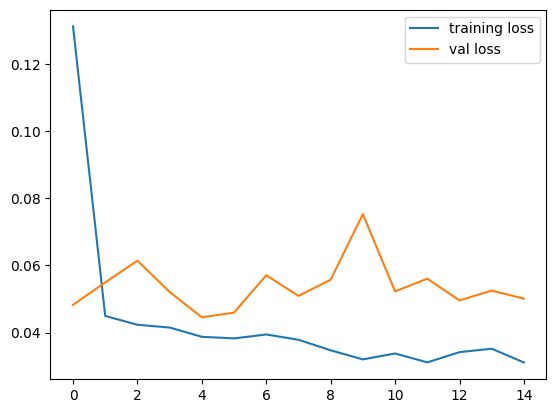

In [127]:
plt.plot(log.history['loss'],label = "training loss")
plt.plot(log.history['val_loss'], label = "val loss")
plt.legend()
plt.show()

Model is overfitting even though we've used batch normalisation or dropout which is supposed to address this. This is likely because the training dataset is not representative of the test set, which is quite common for imbalanced classification problems when the number of frauds is low. It's also possible that the size of the training dataset is not big enough to train a deep neural network.

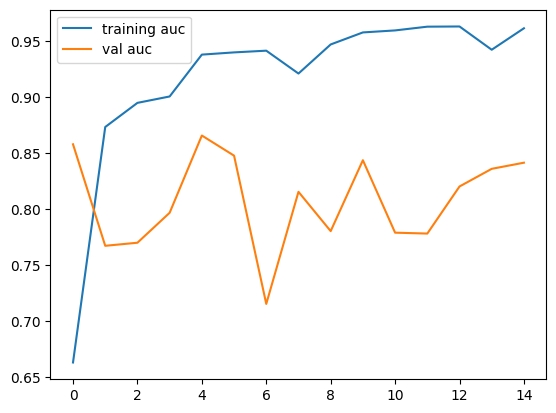

In [128]:
plt.plot(log.history['auc_1'],label = "training auc")
plt.plot(log.history['val_auc_1'], label = "val auc")
plt.legend()
plt.show()

#### Test the model

In [129]:
y_predict = best_model.predict(X_test)

69/69 [==============================] - 0s 2ms/step


In [130]:
# set up the range of threshold
threshold = np.arange(0, 1, 0.01)

In [131]:
def predict(threshold, y_hat):
    all_y_prediction = []
    for i in range(len(threshold)):
        y_prediction = []
        for o in range(len(y_hat)):
            if y_hat[o] >= threshold[i]:
                y = 1
                y_prediction.append(y)
            else:
                y = 0
                y_prediction.append(y)
        all_y_prediction.append(y_prediction)
    return all_y_prediction

In [132]:
all_y_prediction = predict(threshold, y_predict)

In [133]:
def get_detection_rate_and_hit_rate_model_4(all_y_prediction, y_test):
    
    # All_detection rate
    d = []
    # All hit rate
    h = []
    
    for i in range(len(all_y_prediction)):
        
        # The number of detection
        a = 0
        # The number of real fraud
        b = 0
        
        for o, n in zip(all_y_prediction[i], y_test):
            if o == 1:
                a = a + 1
                if n == 1:
                    b = b + 1
            else:
                pass
            
        if a == 0:
            detection_rate = 0
            d.append(detection_rate)
            hit_rate = 0
            h.append(hit_rate)
        else:
            detection_rate = round((a / len(y_test))*100, 2)
            d.append(detection_rate)
            hit_rate = round((b / a)*100, 2)
            h.append(hit_rate)

    
    return d, h

In [134]:
model4_d, model4_h = get_detection_rate_and_hit_rate_model_4(all_y_prediction, y_test)

In [135]:
all_auc = get_all_auc(y_test, all_y_prediction)

Text(0, 0.5, 'AUC')

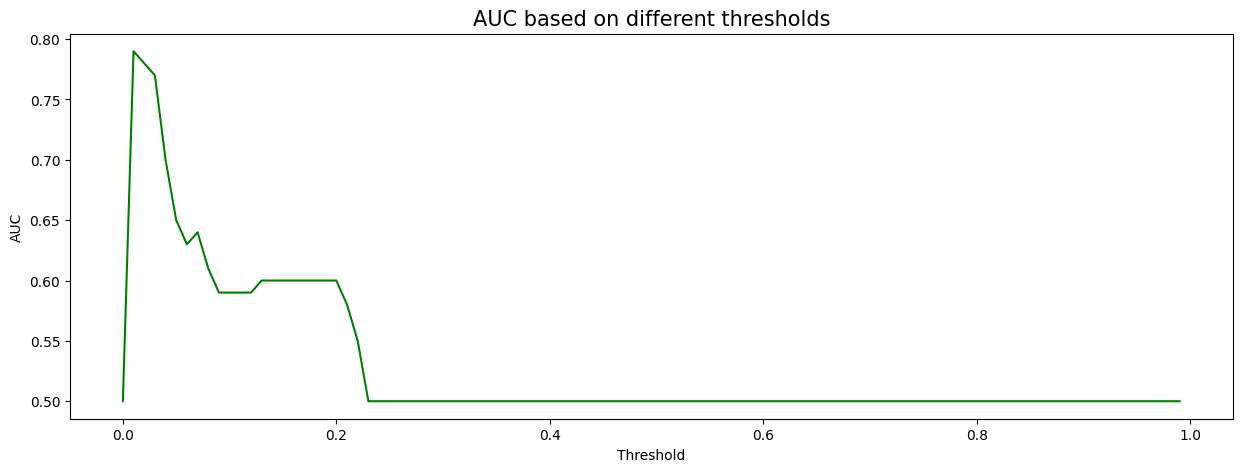

In [136]:
fig = plt.figure(figsize = (15, 5))
AX1 = fig.add_subplot(1,1,1)

AX1.plot(threshold, all_auc, ls = "-", color = "green")

AX1.set_title("AUC based on different thresholds", fontsize = 15, horizontalalignment="center")

AX1.set_xlabel("Threshold", fontsize = 10)
AX1.set_ylabel("AUC", fontsize = 10)

In [137]:
for i in range(len(all_auc)):
    if all_auc[i] == max(all_auc):
        print("The threshold is " + str(threshold[i]))
        print("The detection rate is " + str(model4_d[i]) + "%")
        print("The hit rate is " + str(model4_h[i]) + "%")
        print("The AUC of the model is " + str(all_auc[i]))

        break

auc_nn = all_auc[i]
auc_nn

The threshold is 0.01
The detection rate is 16.71%
The hit rate is 3.85%
The AUC of the model is 0.79


0.79

In [138]:
def get_all_F1_score(y, y_hat):
    F1_score = []
    for i in range(len(y_hat)):
        F1 = round(metrics.f1_score(y, y_hat[i]), 2)
        F1_score.append(F1)
    return F1_score

In [139]:
# F1 score
get_all_F1_score = get_all_F1_score(y_test, all_y_prediction)

Text(0, 0.5, 'F1 score')

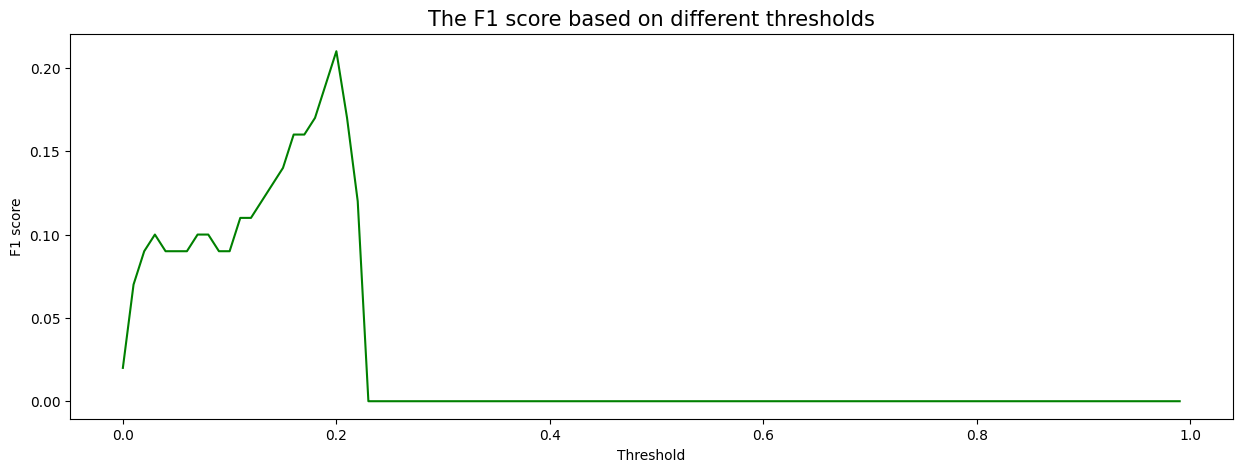

In [140]:
fig = plt.figure(figsize = (15, 5))
AX1 = fig.add_subplot(1,1,1)

AX1.plot(threshold, get_all_F1_score, ls = "-", color = "green")

AX1.set_title("The F1 score based on different thresholds", fontsize = 15, horizontalalignment="center")

AX1.set_xlabel("Threshold", fontsize = 10)
AX1.set_ylabel("F1 score", fontsize = 10)

In [141]:
for i in range(len(get_all_F1_score)):
    if get_all_F1_score[i] == max(get_all_F1_score):
        print("The threshold is " + str(threshold[i]))
        print("The detection rate is " + str(model4_d[i]) + "%")
        print("The hit rate is " + str(model4_h[i]) + "%")
        print("The F1 score of the model is " + str(get_all_F1_score[i]))

        break

f1_nn = get_all_F1_score[i]
nn_h = model4_h[i]
nn_d = model4_d[i]

The threshold is 0.2
The detection rate is 0.92%
The hit rate is 20.0%
The F1 score of the model is 0.21


In [142]:
threshold[2:13]

array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12])

In [143]:
model4_d[2:13]

[12.63, 9.73, 8.03, 6.57, 5.14, 4.59, 3.76, 3.35, 3.03, 2.62, 2.39]

In [144]:
model4_h[2:13]

[4.73, 5.66, 5.14, 4.9, 5.36, 6.0, 6.1, 5.48, 6.06, 7.02, 7.69]

In [145]:
# Compare the detection rates and hit rates of the 4 Models
model_performance = pd.DataFrame(
    {
        'model': ['Heuristic Model', 'Decision Tree Model', 'Random Forest Model', 'Neural Network Model'],
        'detection rate': [d[29], Decision_Tree_d, RF_d, nn_d],
        'hit rate': [h[29], Decision_Tree_h, RF_h, nn_h],
        'auc': [auc_heuristic, auc_dt, auc_rf, auc_nn],
        'f1_score': [f1_heuristic, f1_dt, f1_rf, f1_nn]
    }
).round(2)

model_performance

,model,detection rate,hit rate,auc,f1_score
0,Heuristic Model,5.94,13.16,0.87,0.29
1,Decision Tree Model,8.26,9.44,0.91,0.17
2,Random Forest Model,1.29,21.43,0.95,0.26
3,Neural Network Model,0.92,20.00,0.79,0.21


In [147]:
# Save the neural network model
# best_model.save("nn_model_task5.h5")

## Task 6

In [ ]:
df_nn = df_insurance_claims
df_nn.to_csv("nn_data.csv", index=False)

In [ ]:
print(df_nn.isna().sum())

# drop rows with nan
df_nn = df_nn.dropna().reset_index(drop=True)

PolicyholderOccupation             340
LossDate                             0
FirstPolicySubscriptionDate          0
ClaimCause                         191
FirstPartyVehicleType               12
ConnectionBetweenParties             0
PolicyWasSubscribedOnInternet        0
NumberOfPoliciesOfPolicyholder       0
FpVehicleAgeMonths                   0
EasinessToStage                      0
ClaimWihoutIdentifiedThirdParty      0
ClaimAmount                          0
LossHour                            94
PolicyHolderAge                     36
NumberOfBodilyInjuries               0
FirstPartyLiability                  0
Fraud                                0
Days                                 0
PolicyHolderCount                    0
Accessories                        189
ActLiability                       189
Burglary                           189
Fire                               189
MaterialDamages                    189
MedicalCare                        189
NaturalCatastrophes      

In [ ]:
df_nn.shape

(10889, 32)

In [ ]:
df_nn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10889 entries, 0 to 10888
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   PolicyholderOccupation           10889 non-null  object        
 1   LossDate                         10889 non-null  datetime64[ns]
 2   FirstPolicySubscriptionDate      10889 non-null  datetime64[ns]
 3   ClaimCause                       10889 non-null  object        
 4   FirstPartyVehicleType            10889 non-null  object        
 5   ConnectionBetweenParties         10889 non-null  object        
 6   PolicyWasSubscribedOnInternet    10889 non-null  int64         
 7   NumberOfPoliciesOfPolicyholder   10889 non-null  int64         
 8   FpVehicleAgeMonths               10889 non-null  float64       
 9   EasinessToStage                  10889 non-null  float64       
 10  ClaimWihoutIdentifiedThirdParty  10889 non-null  int64    

In [ ]:
# convert binary columns to ints
df_nn["PolicyWasSubscribedOnInternet"] = df_nn["PolicyWasSubscribedOnInternet"].astype("int64")
df_nn["ClaimWihoutIdentifiedThirdParty"] = df_nn["ClaimWihoutIdentifiedThirdParty"].astype("int64")

# these columns are already encoded
already_encoded = ["Accessories","ActLiability","Burglary","Fire","MaterialDamages","MedicalCare",
                   "NaturalCatastrophes","ReplacementVehicle","RiderClothes","Theft","ThirdParty",
                   "ThirdPartyMaterialDamages","Windscreen"]

# df_nn.drop("ConnectionBetweenParties", axis=1, inplace=True)
# df_nn.drop("PolicyholderOccupation", axis=1, inplace=True)

df_nn.drop("LossDate", axis=1, inplace=True)
df_nn.drop("FirstPolicySubscriptionDate", axis=1, inplace=True)

# find which columns are categorical and which are numerical
categorical_columns = []
numerical_columns = []
for col in df_nn.columns:
    if df_nn[col].dtype not in ['int64', "float64", "uint8", ]:
        categorical_columns.append(col)
    else:
        # not binary data and not previously one-hot encoded
        if col not in ["PolicyWasSubscribedOnInternet", "ClaimWithoutIdentifiedThirdParty", "Fraud"] and col not in already_encoded and df_nn[col].dtype != "uint8":
            numerical_columns.append(col)
print(numerical_columns)
print(categorical_columns)

# one hot encode the categorical columns
df_nn = pd.get_dummies(df_nn, drop_first=True, columns=categorical_columns)

['NumberOfPoliciesOfPolicyholder', 'FpVehicleAgeMonths', 'EasinessToStage', 'ClaimWihoutIdentifiedThirdParty', 'ClaimAmount', 'LossHour', 'PolicyHolderAge', 'NumberOfBodilyInjuries', 'FirstPartyLiability', 'Days', 'PolicyHolderCount']
['PolicyholderOccupation', 'ClaimCause', 'FirstPartyVehicleType', 'ConnectionBetweenParties']


In [ ]:
df_nn.shape

(10889, 61)

In [ ]:
# Splitting the dataset
x = df_nn.drop("Fraud", axis=1)
y = df_nn["Fraud"]

print(x.shape)
print(y.shape)

x_non_fraud = x[y==0]
y_non_fraud = y[y==0]
x_fraud = x[y==1]
y_fraud = y[y==1]
print("----------")
print(x_non_fraud.shape)
print(y_non_fraud.shape)
print(x_fraud.shape)
print(y_fraud.shape)

# split the non fraud data into train and other dataset
x_train, x_other, y_train, y_other = train_test_split(x_non_fraud, y_non_fraud, test_size=0.1, shuffle=True, random_state=300)

# concatenate the other dataset with the fraud cases
x_other = pd.concat((x_other, x_fraud), axis=0)
y_other = pd.concat((y_other, y_fraud), axis=0)
print("----------")
print(x_other.shape)
print(y_other.shape)
print("----------")
# split this into validation and test datasets
x_test, x_valid, y_test, y_valid = train_test_split(x_other, y_other, stratify=y_other, train_size=0.5, shuffle=True, random_state=380)

print('test')
print(x_test[y_test==1].shape)
print(x_test[y_test==0].shape)

print('valid')
print(x_valid[y_valid==1].shape)
print(x_valid[y_valid==0].shape)
print("----------")

(10889, 60)
(10889,)
----------
(10781, 60)
(10781,)
(108, 60)
(108,)
----------
(1187, 60)
(1187,)
----------
test
(54, 60)
(539, 60)
valid
(54, 60)
(540, 60)
----------


In [ ]:
# Scaling the dataset
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x_train[numerical_columns] = min_max_scaler.fit_transform(x_train[numerical_columns])
x_valid[numerical_columns] = min_max_scaler.transform(x_valid[numerical_columns])
x_test[numerical_columns] = min_max_scaler.transform(x_test[numerical_columns])

In [ ]:
# Encoder
encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(x_train.shape[1], )),
    tf.keras.layers.Dense(40, activation="elu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
])

# Decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(40, activation="relu"),
    tf.keras.layers.Dense(x_train.shape[1], activation="sigmoid")
])

# Autoencoder
model = tf.keras.Sequential([encoder, decoder])

model.build(x_train.shape)
encoder.summary()
decoder.summary()
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mse",
              metrics="mse"
              )

history = model.fit(x_train, x_train, batch_size=256, epochs=300, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 40)                2440      
                                                                 
 dense_17 (Dense)            (None, 16)                656       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (9702, 16)                144       
                                                                 
 dense_20 (Dense)            (

In [ ]:
def predict_mse_histogram_validation(model, density=True):
    # predict on the validation data
    x_hat_valid = model.predict(x_valid)
    mse_valid = np.mean((x_valid - x_hat_valid)**2, axis = 1)

    # histgram of the MSE
    plt.hist(mse_valid[y_valid == 0], density=density, color='turquoise', alpha=0.8)
    plt.hist(mse_valid[y_valid == 1], density=density, color='orange', alpha=0.8)
    plt.legend(["non fraud", "fraud"])
    plt.xlabel("MSE")
    # plt.ylabel("count")
    plt.title("MSE histogram on validation data")
    plt.show()

19/19 [==============================] - 0s 2ms/step


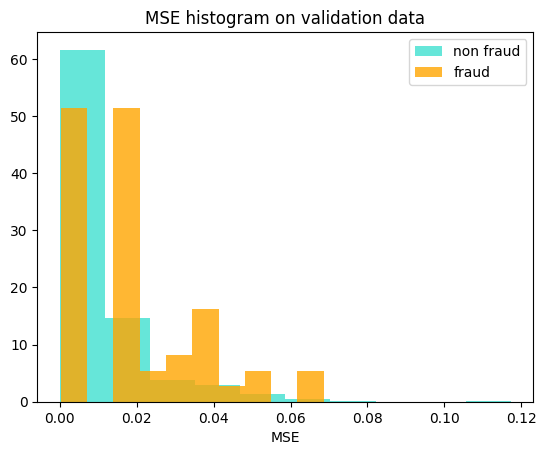

In [ ]:
predict_mse_histogram_validation(model)

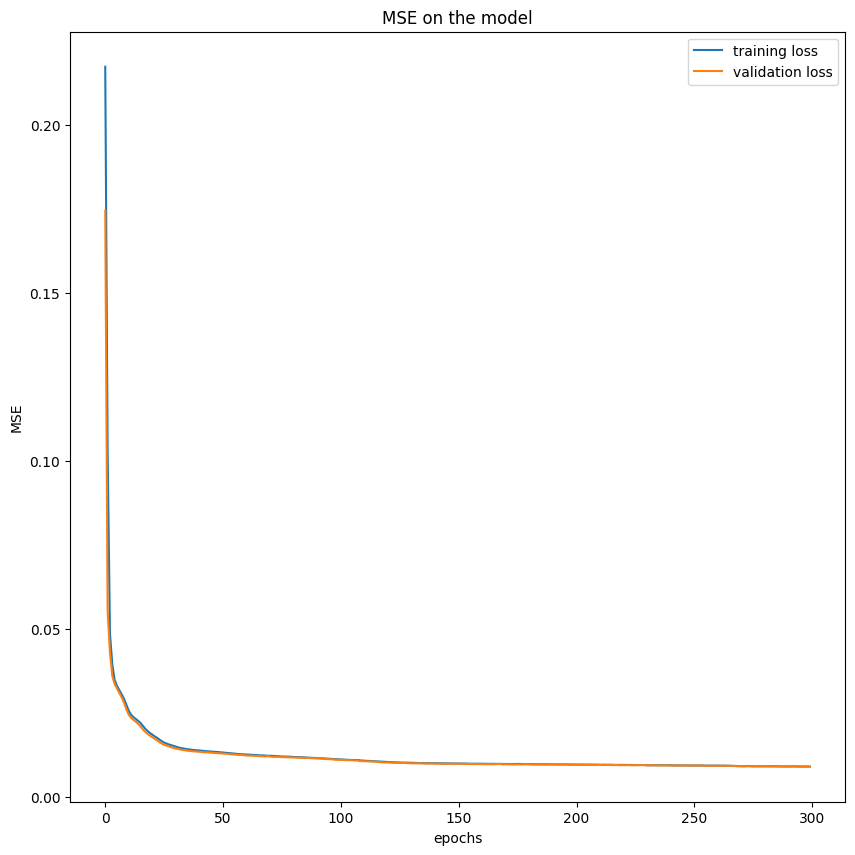

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("MSE on the model")
plt.show()

In [ ]:
import keras_tuner as kt

# hyperparameter tuning
def build(hp):
    # number of hidden units per layer
    num_units_l1 = hp.Int('num_units_l1', min_value = 30, max_value=35)
    num_units_l2 = hp.Int('num_units_l2', min_value = 15, max_value=20)
    num_units_l3 = hp.Int('num_units_l3', min_value = 8, max_value=12)
    num_units_l4 = hp.Int('num_units_l4', min_value = 4, max_value=10)

    tf.keras.Sequential([
        tf.keras.layers.Input(shape=(x_train.shape[1], )),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l1, activation="elu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l2, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l3, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l4, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),

        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l3, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l2, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l1, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(x_train.shape[1], activation="sigmoid")
    ])

    # learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100000, decay_rate=0.9)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mse",
              metrics="mse"
              )

    return model

tuner = kt.Hyperband(
    build,
    objective="val_mse",
    max_epochs=10,
    factor=3,
    directory='loggs',
    project_name='autoencoder' + str(datetime.datetime.now().timestamp())
)

x_tr_nf, x_va_nf, y_tr_nf, y_va_nf = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

tf.keras.backend.clear_session()
tuner.search(x_tr_nf, x_tr_nf, 
             validation_data=(x_va_nf, x_va_nf))

Trial 30 Complete [00h 00m 12s]
val_mse: 0.007462953682988882

Best val_mse So Far: 0.007462953682988882
Total elapsed time: 00h 02m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps['num_units_l1'])
print(best_hps['num_units_l2'])
print(best_hps['num_units_l3'])
print(best_hps['num_units_l4'])

30
16
9
8


In [ ]:
model = tuner.hypermodel.build(best_hps)

# epochs_until_change = 400
# steps_per_epoch = x_train.shape[0] / 256
# steps = epochs_until_change * steps_per_epoch

# # learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=init_learning_rate, decay_steps=steps, decay_rate=0.1)
# learning_rate = 0.001
# step = tf.Variable(0, trainable=False)
# boundaries = [steps, steps*2.5]
# values = [0.01, 0.001, 0.0001]
# learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries, values)

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn),
#               loss="mse",
#               metrics="mse"
#               )

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_mse', min_delta=0.0001, patience=20, restore_best_weights=True)
history = model.fit(x_tr_nf, x_tr_nf, epochs=500, batch_size = 256, validation_data=(x_va_nf, x_va_nf), 
                    callbacks=[early_stopping_cb]
                    )

Epoch 1/500
31/31 [==============================] - 1s 12ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 2/500
31/31 [==============================] - 0s 16ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 7/500
31/31 [==============================] - 0s 10ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 0.0076 

19/19 [==============================] - 0s 2ms/step


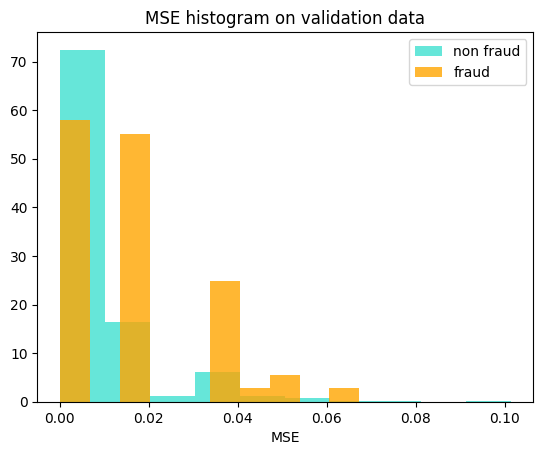

In [ ]:
predict_mse_histogram_validation(model)

In [ ]:
# Save the model
# model.save("q6_autoencoder.h5")

2/2 [==============================] - 0s 4ms/step


<Figure size 1500x500 with 0 Axes>

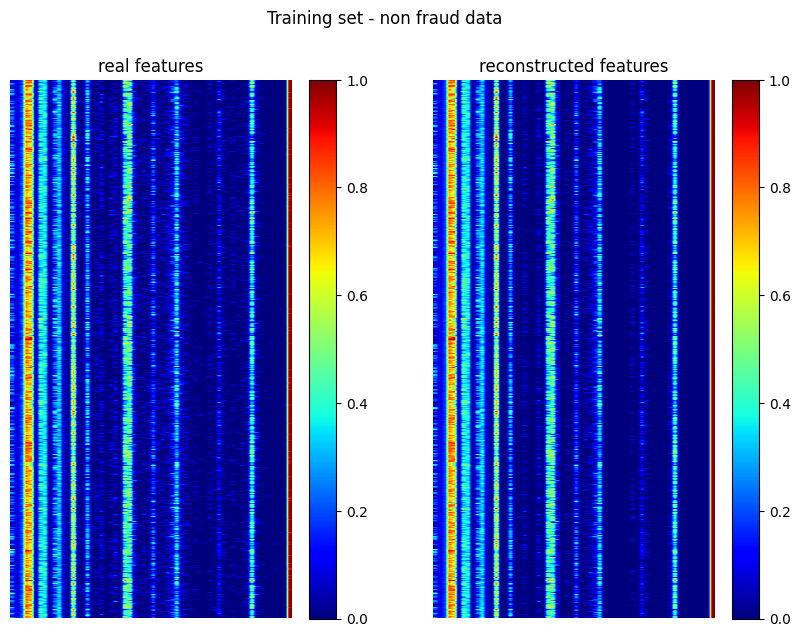

<Figure size 1500x500 with 0 Axes>

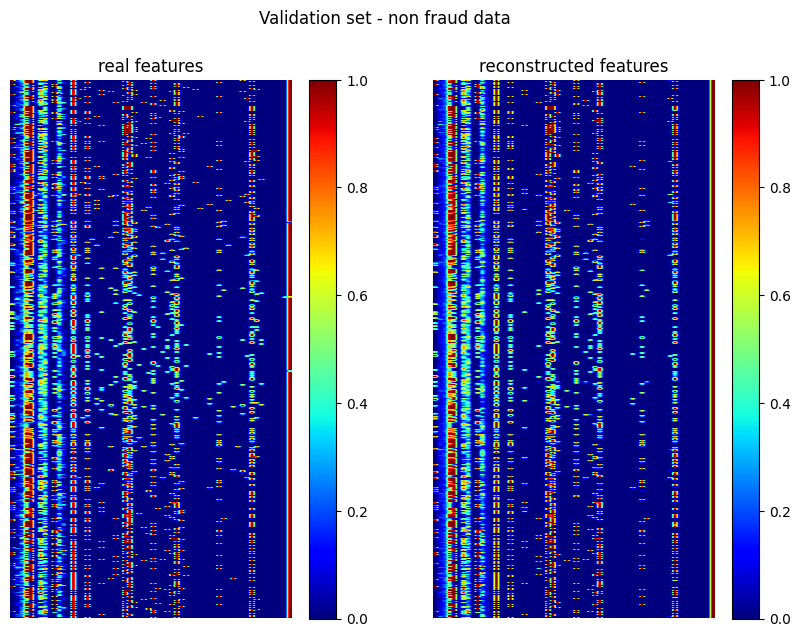

<Figure size 1500x500 with 0 Axes>

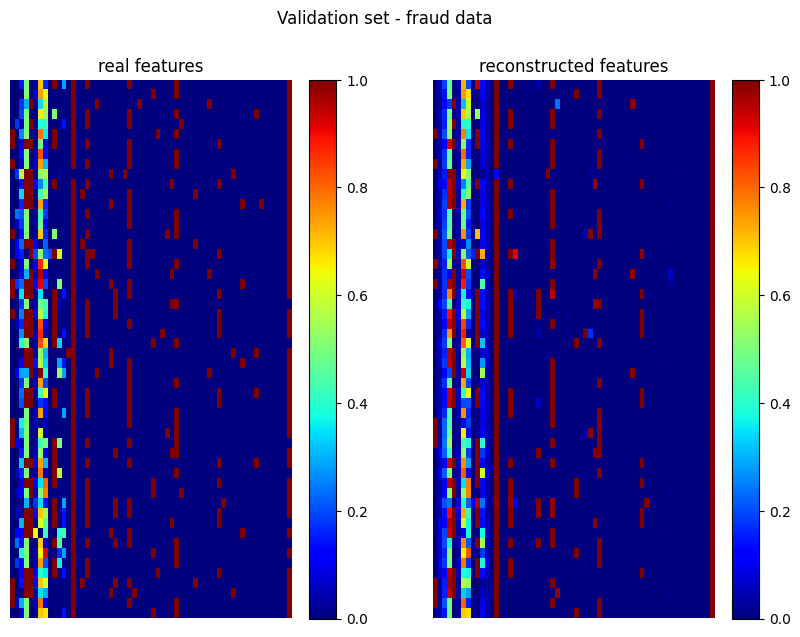

In [ ]:
x_hat_tr_nf = model.predict(x_tr_nf)
# validation data that is non fraud
x_valid_non_fraud = x_valid[y_valid==0]
x_hat_valid_non_fraud = model.predict(x_valid_non_fraud)
# validation data that is fraud
x_valid_fraud = x_valid[y_valid==1]
x_hat_valid_fraud = model.predict(x_valid_fraud)


plt.figure(figsize=(15, 5))
plt.subplots(1,2,figsize=(10,7))
plt.suptitle("Training set - non fraud data")
plt.subplot(1, 2, 1)
plt.imshow(x_tr_nf.to_numpy(), aspect='auto', cmap="jet", interpolation=None, vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.title("real features")
plt.subplot(1, 2, 2)
plt.imshow(x_hat_tr_nf, aspect='auto', cmap="jet", interpolation=None,vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.title("reconstructed features")

plt.figure(figsize=(15, 5))
plt.subplots(1,2,figsize=(10,7))
plt.suptitle("Validation set - non fraud data")
plt.subplot(1, 2, 1)
plt.imshow(x_valid_non_fraud.to_numpy(), aspect='auto', cmap="jet", interpolation=None, vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.title("real features")
plt.subplot(1, 2, 2)
plt.imshow(x_hat_valid_non_fraud, aspect='auto', cmap="jet", interpolation=None, vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.title("reconstructed features")
plt.show()

plt.figure(figsize=(15, 5))
plt.subplots(1,2,figsize=(10,7))
plt.suptitle("Validation set - fraud data")
plt.subplot(1, 2, 1)
plt.imshow(x_valid_fraud.to_numpy(), aspect='auto', cmap="jet", interpolation=None, vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.title("real features")
plt.subplot(1, 2, 2)
plt.imshow(x_hat_valid_fraud, aspect='auto', cmap="jet", interpolation=None, vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.title("reconstructed features")
plt.show()

19/19 [==============================] - 0s 1ms/step


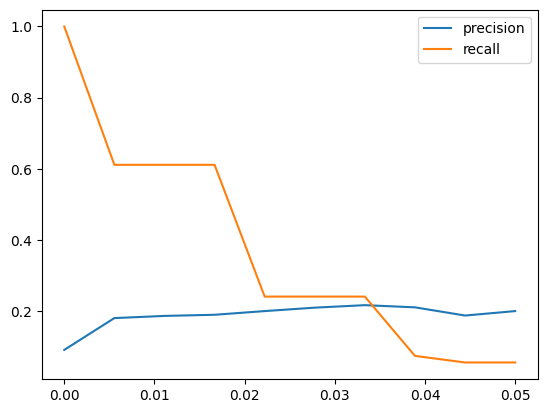

In [ ]:
# draw precision recall curves for various thresholds
from sklearn.metrics import confusion_matrix, recall_score, precision_score

x_hat_valid = model.predict(x_valid)
mse_valid = np.mean((x_hat_valid - x_valid) ** 2, axis=1)

precisions = []
recalls = []
thresholds = np.linspace(0, 0.05, 10)
for t in thresholds:
    y_pred = mse_valid > t
    precisions.append(precision_score(y_valid, y_pred))
    recalls.append(recall_score(y_valid, y_pred))

plt.figure()
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
_=plt.legend(["precision", "recall"])

0.017066607143937755


Text(0.5, 1.0, 'Confusion matrix of the predictions on the validation data')

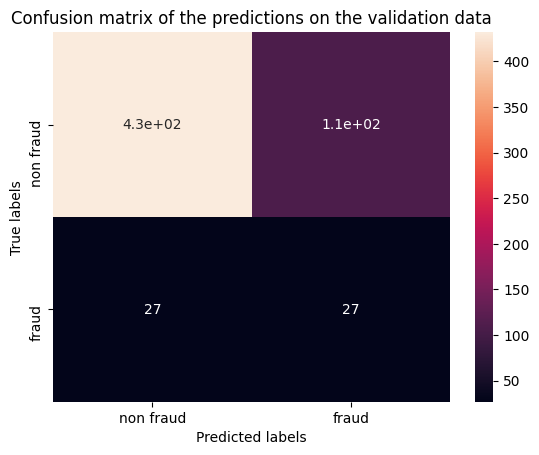

In [ ]:
# We choose a threshold such that 80 percentile of the non fraud validation data
mse_valid_non_fraud = np.mean((x_valid_non_fraud - x_hat_valid_non_fraud) ** 2, axis=1)

threshold = np.percentile(mse_valid_non_fraud, 80)
print(threshold)
y_pred = mse_valid > threshold
cmat = confusion_matrix(y_valid.to_numpy(), y_pred)

plt.figure()
sns.heatmap(cmat, annot=True, xticklabels=["non fraud", "fraud"], yticklabels=["non fraud", "fraud"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix of the predictions on the validation data")

19/19 [==============================] - 0s 2ms/step
Test data size: 593
Suspicious: 156
detection rate: 0.2630691399662732, hit rate: 0.1794871794871795


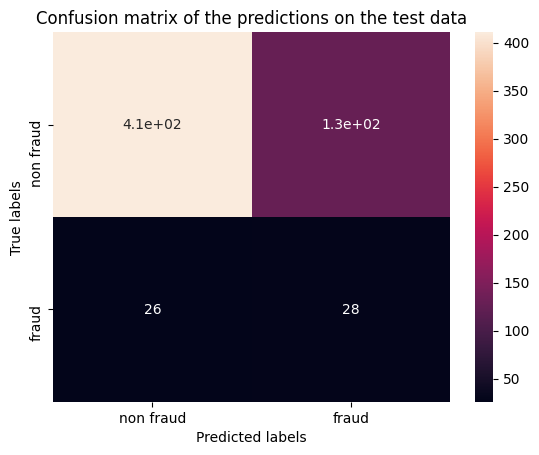

In [ ]:
# prediction on test data
x_hat_test = model.predict(x_test)
mse_test = np.mean((x_test - x_hat_test)**2, axis=1)
# predict fraud/non fraud using the threshold
y_pred_test = mse_test > threshold

# confusion matrix
cmat = confusion_matrix(y_test.to_numpy(), y_pred_test)
plt.figure()
sns.heatmap(cmat, annot=True, xticklabels=["non fraud", "fraud"], yticklabels=["non fraud", "fraud"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix of the predictions on the test data")

# Detection rate and hit rate on the test data
print("Test data size: {}".format(y_pred_test.shape[0]))
print("Suspicious: {}".format(sum(y_pred_test)))

detection_rate = sum(y_pred_test) / y_pred_test.shape[0]
hit_rate = sum(y_pred_test * y_test) / sum(y_pred_test)

print("detection rate: {}, hit rate: {}".format(detection_rate, hit_rate))

In [ ]:
f1_ae = f1_score(y_pred_test, y_test)
f1_ae

0.26666666666666666

## Task 7

The decision tree model exhibits the relatively high detection rate, this leads to raised investigation cost and potentially undermining customer satisfactory rates. For random forest and neural network models, detection rate is nearing 1%, as a result hit rate is much higher. Whereas for the autoencoder model, detection rate is almost 25%, which is not feasible for business in real life because the company cannot afford to run investigations on that large of a scale. This suggests there is potential for further improvement for this model or method. 
Once we have a better grasp of the cost of further investigations and return on spotting a true fraudulent case, then each model can be further evaluated to better reflect the specific business needs.

Why it is problematic when there is no clear explanation why the tool flagged a certain incident as possibly fraudulent:

The transparency of neural network is poor, it does not entail to what extent all the features are affecting the result of label prediction. This is problematic in our case because: 
•	When communicating with the policy holders during further investigations, it is difficult to explain why the case is being investigated, potentially causing confusion and lowering customer satisfactory rates.
•	When investigating flagged cases further, it is unclear which direction to start with due to the lack of transparency lowering operation efficiency and resulting in higher cost.
•	Neural network might be making decisions based on factors that are irrelevant or discriminatory. This could potentially lead to law suits against discrimination, damaging company brand name.  
•	Lack of transparency makes it difficult to adjust its architecture or parameters to improve its performance because we do not understand how neural networks is making its decisions. This is a significant issue because accuracy (detection rate, hit rate) is critical in our specific case.

## Task 8: Other approaches dealing with imbalanced dataset

To address the class imbalance and improve the prediction of fraud, other approaches can be employed apart from threshold adjustment. Resampling methods such as over-sampling the minority class and under-sampling the majority class can be used for balanced classes.

Another approach is Cost-sensitive learning which assigns a cost value to misclassifications of various classes, based on a cost matrix that identifies different types of errors. This will help to adjust the cost function to account for the imbalanced data, giving more weight to the minority class. 

Synthetic Minority Oversampling Technique (SMOTE) is one which generates synthetic instances from existing minority class data, creating a more balanced dataset. Ensemble approach can be particularly effective in dealing with imbalanced data because they allow for different models to be used for different subsets of the data, optimizing performance for each class. By utilizing a combination of these approaches, performance can be significantly improved.